In [46]:
import os
import random
import re

from datetime import datetime

import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
from dask import compute, delayed
from dask.distributed import Client
from pymannkendall import seasonal_sens_slope, seasonal_test
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import to_rgb
import matplotlib.dates as mdates
import ephem
import gc

---
---
## 1. Load and prepare data

In [2]:
# Specify towers and variables of interest
towers_of_interest = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']
vars = ['TempC',
        'RelHum', 'AbsHum', 
        'WSpdMph', 'PkWSpdMph', 'VSSpdMph',
        'SolarRadWm2', 
        'BarPresMb',
        'Sigma', 'SigPhi',
        'WDir',
        'PrecipIn']

# Load final quality assessed data and format datetime
tower_dfs_15m_clean = []
for tower in towers_of_interest:
    
    df = pd.read_csv(f'../data/met_towers_2017-2022_final-qc/{tower}_2017-2022_final-qc.csv', header=0, 
                     skipfooter=1, na_values=[-999, '-999'], engine='python', 
                     parse_dates=True)
    
    df['timestampUTC'] = pd.to_datetime(df['timestampUTC'], format='%Y%m%d%H%M%S').dt.tz_localize('UTC')
    df = df.set_index('timestampUTC', drop=True)

    tower_dfs_15m_clean.append(df)

In [3]:
tower_dfs_15m_clean[0]

,TempC_015m,TempC_030m,RelHum_015m,AbsHum_015m,WSpdMph_015m,WSpdMph_030m,PkWSpdMph_015m,PkWSpdMph_030m,VSSpdMph_015m,VSSpdMph_030m,BarPresMb_015m,Sigma_015m,Sigma_030m,SigPhi_015m,SigPhi_030m,WDir_015m,WDir_030m,PrecipIn_015m
timestampUTC,,,,,,,,,,,,,,,,,,
2017-01-01 05:00:00+00:00,3.6,3.6,97.4,6.0,2.2,4.4,5.9,10.2,0.0,-0.100000,985.3,26.5,15.5,18.9,12.6,268.0,274.0,0.015748
2017-01-01 05:15:00+00:00,3.6,3.6,97.3,6.0,2.4,4.7,6.7,7.7,0.0,-0.100000,985.3,19.3,13.9,14.3,9.8,252.0,264.0,0.011811
2017-01-01 05:30:00+00:00,3.6,3.7,97.4,6.0,2.8,4.3,6.0,6.8,-0.2,0.000064,985.2,25.3,15.0,13.6,11.0,255.0,260.0,0.011811
2017-01-01 05:45:00+00:00,3.7,3.7,97.4,6.0,2.5,4.2,5.1,6.8,-0.2,-0.100000,985.0,29.4,16.6,14.4,8.3,268.0,263.0,0.007874
2017-01-01 06:00:00+00:00,3.8,3.8,97.3,6.0,2.2,4.0,4.2,6.3,0.0,0.100000,985.1,25.0,13.1,14.9,10.8,268.0,274.0,0.007874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01 03:30:00+00:00,10.1,12.3,98.5,9.2,0.4,2.6,NaN,NaN,0.0,NaN,984.4,78.6,11.0,12.9,3.4,120.7,248.9,0.000000
2023-01-01 03:45:00+00:00,10.2,11.8,98.6,9.3,0.2,2.5,NaN,NaN,0.0,NaN,984.4,66.5,15.0,5.7,3.8,273.6,263.7,0.000000
2023-01-01 04:00:00+00:00,10.4,11.7,98.6,9.4,0.7,3.1,NaN,NaN,0.0,NaN,984.5,45.9,15.7,12.4,4.8,253.0,259.9,0.000000


In [4]:
# Combine the DataFrames
combined_df = pd.concat([df.assign(tower=tower_name) for df, tower_name in zip(tower_dfs_15m_clean, towers_of_interest)])

# Add a year column
combined_df['year'] = combined_df.index.year
combined_df['month'] = combined_df.index.month

# Melt the DataFrame
melted_df = pd.melt(combined_df, id_vars=['tower', 'year', 'month'], var_name='variable_height', value_name='value')

# Split the columns
melted_df[['variable', 'height']] = melted_df['variable_height'].str.split('_', expand=True, n=1)

In [5]:
tower_dfs_15m_clean[0].index.dtype

datetime64[ns, UTC]

---
---
# 2. Timeseries Plots

In [6]:
# Label conversions for variable names
label_conversions = {
    'TempC': 'Temperature (°C)',
    'RelHum': 'Relative Humidity (%)',
    'AbsHum': 'Absolute Humidity (g/m\N{SUPERSCRIPT THREE})',
    'WSpdMph': 'Lateral Wind Speed (mph)',
    'PkWSpdMph': 'Peak Lateral Wind Speed (mph)',
    'VSSpdMph': 'Vertical Wind Speed (mph)',
    'BarPresMb': 'Pressure (mb)',
    'Sigma': r'$\sigma_\theta$ (degree)',
    'SigPhi': r'$\sigma_\phi$ (degree)',
    'WDir': 'Wind Direction (degree)',
    'PrecipIn': 'Precipitation (in)',
    'SolarRadWm2': 'Solar Radiation (W/m\N{SUPERSCRIPT TWO})'
}

## 2.a. Multi-annual Timeseries

In [7]:
# Function to slightly lighten a base color
def lighten_color(base_color, num_heights, min_lighten=0.0, max_lighten=0.2):
    """
    Generate solid colors by slightly adding white to a base color.
    """
    base_rgb = np.array(to_rgb(base_color))  # Convert base color to RGB
    lighten_steps = np.linspace(min_lighten, max_lighten, num_heights)
    colors = [
        (1 - lighten_step) * base_rgb + lighten_step * np.ones(3)
        for lighten_step in lighten_steps
    ]
    return colors

# Use ColorBrewer Set3 for variables
set3_colors = sns.color_palette("Set3", 15)
set3_filtered = [color for i, color in enumerate(set3_colors) if i not in [1, 11, 13]]  # Exclude yellow
variable_to_base_color = dict(zip(vars, set3_filtered[:len(vars)]))

# Create plots for each tower
for tower, tower_15m_df_clean in zip(towers_of_interest, tower_dfs_15m_clean):
    # Initialize a figure for the current tower
    fig, axs = plt.subplots(6, 2, figsize=(20, 30), sharex=True)
    axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

    for ax, variable, idx in zip(axs, vars, range(len(axs))):
        variable_columns = [col for col in tower_15m_df_clean.columns if col.startswith(variable)]
        base_color = variable_to_base_color[variable]  # Get the base color for the variable

        # Generate progressively lighter colors for heights
        heights = sorted(set(col.split('_')[1] for col in variable_columns))
        height_to_color = dict(zip(heights, lighten_color(base_color, len(heights), min_lighten=0.05, max_lighten=0.15)))

        if variable_columns:
            data = tower_15m_df_clean[variable_columns]

            if not data.empty and not data.isna().all().all():
                handles = []  # For legend
                labels = []   # For legend

                for height in heights:
                    columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                    color = height_to_color[height]  # Assign a unique lightened color to the height

                    for column in columns_with_height:
                        if not data[column].isna().all():
                            try:
                                x, y = zip(*sorted(zip(data.index, data[column])))
                                line, = ax.plot(x, y, color=color, linewidth=1.5, label=f'{height.lstrip("0").replace("m", "")}-m')
                                if height not in labels:
                                    handles.append(line)
                                    labels.append(f'{height.lstrip("0").replace("m", "")}-m')
                            except Exception as e:
                                print(f'Issue with cleaned data for {tower} {column}: {e}')
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)

        # Configure subplot
        full_label = label_conversions.get(variable, variable)  # Use conversion or fallback to variable name
        subplot_title = re.sub(r'\s*\(.*?\)', '', full_label)  # Remove text in parentheses for title
        y_axis_label = re.search(r'\((.*?)\)', full_label)  # Extract text in parentheses for y-axis
        y_axis_label = y_axis_label.group(1) if y_axis_label else ''  # Use extracted text or empty string

        ax.set_title(subplot_title, fontsize=18)  # Subplot title without units
        ax.set_ylabel(y_axis_label, fontsize=14)  # Y-axis label with units
        ax.grid(which='both')

        # Format x-axis for timestamps as 'YYYY-MM-DD HH:MM'
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)

        # Rotate x-axis labels for better readability
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        if idx >= 10:  # Bottom row only (subplots 10 and 11)
            ax.set_xlabel('Date', fontsize=14)

        # Add legend
        ax.legend(handles=handles, labels=labels, title='Height', loc='upper right', fontsize=14, title_fontsize=14)

    # Remove unused subplots if vars < 12
    for idx in range(len(vars), len(axs)):
        fig.delaxes(axs[idx])

    # Configure figure
    fig.suptitle(f'Tower {tower[-1]} 5-year timeseries from 2017–2022', fontsize=24)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    # Save the figure for this tower
    save_path = f'../graphics/timeseries/multi-annual/{tower}_2017–2022.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path)

    plt.close(fig)

Saving image to ../graphics/timeseries/multi-annual/TOWA_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/TOWB_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/TOWD_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/TOWF_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/TOWS_2017–2022.png
Saving image to ../graphics/timeseries/multi-annual/TOWY_2017–2022.png


## 2.b. Annual Timeseries

In [8]:
# Function to slightly lighten a base color
def lighten_color(base_color, num_heights, min_lighten=0.0, max_lighten=0.4):
    """
    Generate solid colors by slightly adding white to a base color.
    """
    base_rgb = np.array(to_rgb(base_color))  # Convert base color to RGB
    lighten_steps = np.linspace(min_lighten, max_lighten, num_heights)
    colors = [
        (1 - lighten_step) * base_rgb + lighten_step * np.ones(3)
        for lighten_step in lighten_steps
    ]
    return colors

# Use ColorBrewer tab20 for variables
set3_colors = sns.color_palette("tab20", 20)
variable_to_base_color = dict(zip(vars, set3_colors[:len(vars)]))

# Label conversions for variable names
label_conversions = {
    'TempC': 'Temperature (°C)',
    'RelHum': 'Relative Humidity (%)',
    'AbsHum': 'Absolute Humidity (g/m\N{SUPERSCRIPT THREE})',
    'WSpdMph': 'Lateral Wind Speed (mph)',
    'PkWSpdMph': 'Peak Lateral Wind Speed (mph)',
    'VSSpdMph': 'Vertical Wind Speed (mph)',
    'BarPresMb': 'Pressure (mb)',
    'Sigma': r'$\sigma_\theta$ (degree)',
    'SigPhi': r'$\sigma_\phi$ (degree)',
    'WDir': 'Wind Direction (degree)',
    'PrecipIn': 'Precipitation (in)',
    'SolarRadWm2': 'Solar Radiation (W/m\N{SUPERSCRIPT TWO})'
}

# Create annual plots for each tower
for tower, tower_15m_df_clean in zip(towers_of_interest, tower_dfs_15m_clean):
    # Extract the year from the datetime index
    tower_15m_df_clean['year'] = tower_15m_df_clean.index.year

    # Get unique years
    years = sorted(tower_15m_df_clean['year'].unique())

    for year in years:
        # Filter data for the current year
        year_data = tower_15m_df_clean[tower_15m_df_clean['year'] == year]

        # Initialize a figure for the current tower-year
        fig, axs = plt.subplots(6, 2, figsize=(20, 30), sharex=True)
        axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

        for ax, variable, idx in zip(axs, vars, range(len(axs))):
            variable_columns = [col for col in year_data.columns if col.startswith(variable)]
            base_color = variable_to_base_color[variable]  # Get the base color for the variable

            # Generate progressively lighter colors for heights
            heights = sorted(set(col.split('_')[1] for col in variable_columns if '_' in col))
            height_to_color = dict(zip(heights, lighten_color(base_color, len(heights), min_lighten=0.05, max_lighten=0.4)))

            line_styles = ['solid', 'dashed', 'dotted', 'dashdot']  # Add line styles

            if variable_columns:
                data = year_data[variable_columns]

                if not data.empty and not data.isna().all().all():
                    handles = []  # For legend
                    labels = []   # For legend

                    for i, height in enumerate(heights):
                        columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                        color = height_to_color[height]  # Assign a unique lightened color to the height
                        style = line_styles[i % len(line_styles)]  # Rotate styles

                        for column in columns_with_height:
                            if not data[column].isna().all():
                                try:
                                    x = data.index
                                    y = data[column]
                                    line, = ax.plot(x, y, color=color, linestyle=style, linewidth=1.5, alpha=0.8, label=f'{height.lstrip("0").replace("m", "")}-m')
                                    if height not in labels:
                                        handles.append(line)
                                        labels.append(f'{height.lstrip("0").replace("m", "")}-m')
                                except Exception as e:
                                    print(f'Issue with cleaned data for {tower} {column}: {e}')
                else:
                    ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)

            # Configure subplot
            full_label = label_conversions.get(variable, variable)  # Use conversion or fallback to variable name
            subplot_title = re.sub(r'\s*\(.*?\)', '', full_label)  # Remove text in parentheses for title
            y_axis_label = re.search(r'\((.*?)\)', full_label)  # Extract text in parentheses for y-axis
            y_axis_label = y_axis_label.group(1) if y_axis_label else ''  # Use extracted text or empty string

            ax.set_title(subplot_title, fontsize=18)  # Subplot title without units
            ax.set_ylabel(y_axis_label, fontsize=14)  # Y-axis label with units
            ax.grid(which='both')

            # Format x-axis for timestamps as 'YYYY-MM-DD HH:MM'
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

            # Rotate x-axis labels for better readability
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=14)
            if idx >= 10:  # Bottom row only (subplots 10 and 11)
                ax.set_xlabel('Date', fontsize=14)

            # Add legend
            ax.legend(handles=handles, labels=labels, title='Height', loc='upper right', fontsize=14, title_fontsize=14)

        # Remove unused subplots if vars < 12
        for idx in range(len(vars), len(axs)):
            fig.delaxes(axs[idx])

        # Configure figure
        fig.suptitle(f'Tower {tower[-1]} timeseries for {year}', fontsize=24)
        fig.tight_layout(rect=[0, 0, 1, 0.98])

        # Save the figure for this tower-year
        save_path = f'../graphics/timeseries/annual/{tower}_{year}.png'
        directory = os.path.dirname(save_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(f'Saving image to {save_path}')
        fig.savefig(save_path, dpi=150)

        plt.close(fig)

Saving image to ../graphics/timeseries/annual/TOWA_2017.png
Saving image to ../graphics/timeseries/annual/TOWA_2018.png
Saving image to ../graphics/timeseries/annual/TOWA_2019.png
Saving image to ../graphics/timeseries/annual/TOWA_2020.png
Saving image to ../graphics/timeseries/annual/TOWA_2021.png
Saving image to ../graphics/timeseries/annual/TOWA_2022.png
Saving image to ../graphics/timeseries/annual/TOWA_2023.png
Saving image to ../graphics/timeseries/annual/TOWB_2017.png
Saving image to ../graphics/timeseries/annual/TOWB_2018.png
Saving image to ../graphics/timeseries/annual/TOWB_2019.png
Saving image to ../graphics/timeseries/annual/TOWB_2020.png
Saving image to ../graphics/timeseries/annual/TOWB_2021.png
Saving image to ../graphics/timeseries/annual/TOWB_2022.png
Saving image to ../graphics/timeseries/annual/TOWB_2023.png
Saving image to ../graphics/timeseries/annual/TOWD_2017.png
Saving image to ../graphics/timeseries/annual/TOWD_2018.png
Saving image to ../graphics/timeseries/a

## 2.c. Monthly timeseries

### This code block is not optimized and could take over an hour to produce all 400+ images

In [9]:
# Function to slightly lighten a base color
def lighten_color(base_color, num_heights, min_lighten=0.0, max_lighten=0.4):
    """
    Generate solid colors by slightly adding white to a base color.
    
    Parameters:
    - base_color: The base RGB color (as a tuple).
    - num_heights: The number of heights to differentiate.
    - min_lighten: The minimum amount of white to add (0 = no lightening).
    - max_lighten: The maximum amount of white to add (0 = no lightening).
    """
    base_rgb = np.array(to_rgb(base_color))  # Convert base color to RGB
    lighten_steps = np.linspace(min_lighten, max_lighten, num_heights)
    colors = [
        (1 - lighten_step) * base_rgb + lighten_step * np.ones(3)
        for lighten_step in lighten_steps
    ]
    return colors

# Use ColorBrewer tab20 for the variables for better contrast
set3_colors = sns.color_palette("tab20", 20)

# Assign colors to variables
variable_to_base_color = dict(zip(vars, set3_colors[:len(vars)]))

# Create plots for each tower, year, and month
for tower, tower_15m_df_clean in zip(towers_of_interest, tower_dfs_15m_clean):
    # Extract the years and months from the index (assuming a datetime index)
    tower_15m_df_clean['year'] = tower_15m_df_clean.index.year
    tower_15m_df_clean['month'] = tower_15m_df_clean.index.month

    years = sorted(tower_15m_df_clean['year'].unique())

    for year in years:
        year_data = tower_15m_df_clean[tower_15m_df_clean['year'] == year]

        # Iterate over months
        for month in sorted(year_data['month'].unique()):
            # Filter data for the current month
            month_data = year_data[year_data['month'] == month]

            # Initialize a figure for the current tower-year-month
            fig, axs = plt.subplots(6, 2, figsize=(20, 30), sharex=True)
            axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

            for ax, variable, idx in zip(axs, vars, range(len(axs))):
                variable_columns = [col for col in month_data.columns if col.startswith(variable)]
                base_color = variable_to_base_color[variable]  # Get the base color for the variable

                # Generate progressively lighter colors for heights
                heights = sorted(set(col.split('_')[1] for col in variable_columns if '_' in col))
                height_to_color = dict(zip(heights, lighten_color(base_color, len(heights), min_lighten=0.05, max_lighten=0.4)))

                line_styles = ['solid', 'dashed', 'dotted', 'dashdot']  # Add line styles

                if variable_columns:
                    data = month_data[variable_columns]

                    if not data.empty and not data.isna().all().all():
                        handles = []  # For legend
                        labels = []   # For legend

                        for i, height in enumerate(heights):
                            columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                            color = height_to_color[height]  # Assign a unique lightened color to the height
                            style = line_styles[i % len(line_styles)]  # Rotate styles

                            for column in columns_with_height:
                                if not data[column].isna().all():
                                    try:
                                        x = data.index
                                        y = data[column]
                                        line, = ax.plot(x, y, color=color, linestyle=style, linewidth=1.5, alpha=0.8, label=f'{height} m')
                                        if height not in labels:
                                            handles.append(line)
                                            labels.append(f'{height.lstrip("0").replace("m", "")}-m')
                                    except Exception as e:
                                        print(f'Issue with cleaned data for {tower} {column}: {e}')
                    else:
                        ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)
                else:
                    ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)

                # Configure subplot
                full_label = label_conversions.get(variable, variable)  # Use conversion or fallback to variable name
                subplot_title = re.sub(r'\s*\(.*?\)', '', full_label)  # Remove text in parentheses for title
                y_axis_label = re.search(r'\((.*?)\)', full_label)  # Extract text in parentheses for y-axis
                y_axis_label = y_axis_label.group(1) if y_axis_label else ''  # Use extracted text or empty string

                # Configure subplot
                ax.set_title(f'{subplot_title}', fontsize=18)
                ax.set_ylabel(y_axis_label, fontsize=14)
                ax.grid(which='both')

                # Format x-axis for timestamps as 'YYYY-MM-DD HH:MM'
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y %H:%M'))
        
                # Rotate x-axis labels for better readability
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
                ax.tick_params(axis='both', which='major', labelsize=14)
                ax.tick_params(axis='both', which='minor', labelsize=14)
                if idx >= 10:  # Bottom row only (subplots 10 and 11)
                    ax.set_xlabel('Date', fontsize=14)

                # Add legend
                ax.legend(handles=handles, labels=labels, title='Height', loc='upper right', fontsize=14, title_fontsize=14)

            # Remove unused subplots if vars < 12
            for idx in range(len(vars), len(axs)):
                fig.delaxes(axs[idx])

            # Configure figure
            formatted_date = datetime(year, month, 1).strftime('%b %Y')
            fig.suptitle(f'Tower {tower[-1]} timeseries for {formatted_date}', fontsize=24)
            fig.tight_layout(rect=[0, 0, 1, 0.98])

            # Save the figure for this tower-year-month
            save_path = f'../graphics/timeseries/monthly/{tower}_{year}_{month:02d}.png'
            directory = os.path.dirname(save_path)
            if not os.path.exists(directory):
                os.makedirs(directory)
            print(f'Saving image to {save_path}')
            fig.savefig(save_path, dpi=150)

            plt.close(fig)

Saving image to ../graphics/timeseries/monthly/TOWA_2017_01.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_02.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_03.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_04.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_05.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_06.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_07.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_08.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_09.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_10.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_11.png
Saving image to ../graphics/timeseries/monthly/TOWA_2017_12.png
Saving image to ../graphics/timeseries/monthly/TOWA_2018_01.png
Saving image to ../graphics/timeseries/monthly/TOWA_2018_02.png
Saving image to ../graphics/timeseries/monthly/TOWA_2018_03.png
Saving image to ../graphics/timeseries/m

## 2.d. Daily timeseries (Random day per month)

In [10]:
# Function to slightly lighten a base color
def lighten_color(base_color, num_heights, min_lighten=0.0, max_lighten=0.4):
    """
    Generate solid colors by slightly adding white to a base color.
    """
    base_rgb = np.array(to_rgb(base_color))  # Convert base color to RGB
    lighten_steps = np.linspace(min_lighten, max_lighten, num_heights)
    colors = [
        (1 - lighten_step) * base_rgb + lighten_step * np.ones(3)
        for lighten_step in lighten_steps
    ]
    return colors

# Use ColorBrewer Set3 for the variables
set3_colors = sns.color_palette("tab20", 20)  # Use tab20 for better contrast
variable_to_base_color = dict(zip(vars, set3_colors[:len(vars)]))

# Create plots for each tower and random day
for tower, tower_15m_df_clean in zip(towers_of_interest, tower_dfs_15m_clean):
    while True:
        # Randomly select a year, month, and day
        random_year = random.randint(2017, 2022)
        random_month = random.randint(1, 12)
        random_day = random.randint(1, 28)  # To avoid day overflow issues

        # Filter data for the random year, month, and day
        selected_data = tower_15m_df_clean[
            (tower_15m_df_clean.index.year == random_year) &
            (tower_15m_df_clean.index.month == random_month) &
            (tower_15m_df_clean.index.day == random_day)
        ]

        # If no data exists, try again
        if not selected_data.empty:
            break

    # Initialize a figure for the random day
    fig, axs = plt.subplots(6, 2, figsize=(20, 30), sharex=True)
    axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

    for ax, variable, idx in zip(axs, vars, range(len(axs))):
        variable_columns = [col for col in selected_data.columns if col.startswith(variable)]
        base_color = variable_to_base_color[variable]  # Get the base color for the variable

        # Generate progressively lighter colors for heights
        heights = sorted(set(col.split('_')[1] for col in variable_columns if '_' in col))
        height_to_color = dict(zip(heights, lighten_color(base_color, len(heights), min_lighten=0.05, max_lighten=0.4)))

        line_styles = ['solid', 'dashed', 'dotted', 'dashdot']  # Add line styles

        if variable_columns:
            if not selected_data[variable_columns].empty and not selected_data[variable_columns].isna().all().all():
                handles = []  # For legend
                labels = []   # For legend

                for i, height in enumerate(heights):
                    columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                    color = height_to_color[height]  # Assign a unique lightened color to the height
                    style = line_styles[i % len(line_styles)]  # Rotate styles

                    for column in columns_with_height:
                        if not selected_data[column].isna().all():
                            try:
                                x = selected_data.index  # Use the datetime index
                                y = selected_data[column]
                                line, = ax.plot(x, y, color=color, linestyle=style, linewidth=1.5, alpha=0.8, label=f'{height.lstrip("0").replace("m", "")}-m')
                                if height not in labels:
                                    handles.append(line)
                                    labels.append(f'{height.lstrip("0").replace("m", "")}-m')
                            except Exception as e:
                                print(f'Issue with cleaned data for {tower} {column}: {e}')
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)

        # Configure subplot
        full_label = label_conversions.get(variable, variable)  # Use conversion or fallback to variable name
        subplot_title = re.sub(r'\s*\(.*?\)', '', full_label)  # Remove text in parentheses for title
        y_axis_label = re.search(r'\((.*?)\)', full_label)  # Extract text in parentheses for y-axis
        y_axis_label = y_axis_label.group(1) if y_axis_label else ''  # Use extracted text or empty string

        # Configure subplot
        ax.set_title(f'{subplot_title}', fontsize=18)
        ax.set_ylabel(y_axis_label, fontsize=14)
        ax.grid(which='both')

        # Format x-axis for timestamps as 'YYYY-MM-DD HH:MM'
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

        # Rotate x-axis labels for better readability
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)
        if idx >= 10:  # Bottom row only (subplots 10 and 11)
            ax.set_xlabel('Date', fontsize=14)

        # Add legend
        ax.legend(handles=handles, labels=labels, title='Height', loc='upper right', fontsize=14, title_fontsize=14)

    # Remove unused subplots if vars < 12
    for idx in range(len(vars), len(axs)):
        fig.delaxes(axs[idx])

    # Configure figure
    formatted_date = datetime(random_year, random_month, random_day).strftime('%d %b %Y')
    fig.suptitle(f'Tower {tower[-1]} timeseries on {formatted_date}', fontsize=24)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    # Save the figure for this tower and random day
    save_path = f'../graphics/timeseries/random_day/{tower}_{random_year}{random_month:02d}{random_day:02d}.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path, dpi=150)

    plt.close(fig)

Saving image to ../graphics/timeseries/random_day/TOWA_20180407.png
Saving image to ../graphics/timeseries/random_day/TOWB_20220407.png
Saving image to ../graphics/timeseries/random_day/TOWD_20180319.png
Saving image to ../graphics/timeseries/random_day/TOWF_20180421.png
Saving image to ../graphics/timeseries/random_day/TOWS_20170311.png
Saving image to ../graphics/timeseries/random_day/TOWY_20210423.png


In [11]:
# Function to slightly lighten a base color
def lighten_color(base_color, num_heights, min_lighten=0.0, max_lighten=0.4):
    """
    Generate solid colors by slightly adding white to a base color.
    """
    base_rgb = np.array(to_rgb(base_color))  # Convert base color to RGB
    lighten_steps = np.linspace(min_lighten, max_lighten, num_heights)
    colors = [
        (1 - lighten_step) * base_rgb + lighten_step * np.ones(3)
        for lighten_step in lighten_steps
    ]
    return colors

# Use ColorBrewer Set3 for the variables
set3_colors = sns.color_palette("tab20", 20)  # Use tab20 for better contrast
variable_to_base_color = dict(zip(vars, set3_colors[:len(vars)]))

def plot_specific_day(tower_name, date_str):
    # Parse the date string
    selected_date = pd.to_datetime(date_str)
    selected_year = selected_date.year
    selected_month = selected_date.month
    selected_day = selected_date.day

    # Get the tower dataframe
    tower_index = towers_of_interest.index(tower_name)
    tower_15m_df_clean = tower_dfs_15m_clean[tower_index]

    # Filter data for the specific day
    selected_data = tower_15m_df_clean[
        (tower_15m_df_clean.index.year == selected_year) &
        (tower_15m_df_clean.index.month == selected_month) &
        (tower_15m_df_clean.index.day == selected_day)
    ]

    # Initialize a figure
    fig, axs = plt.subplots(6, 2, figsize=(20, 30), sharex=True)
    axs = axs.flatten()

    for ax, variable, idx in zip(axs, vars, range(len(axs))):
        variable_columns = [col for col in selected_data.columns if col.startswith(variable)]
        base_color = variable_to_base_color[variable]

        heights = sorted(set(col.split('_')[1] for col in variable_columns if '_' in col))
        height_to_color = dict(zip(heights, lighten_color(base_color, len(heights), min_lighten=0.05, max_lighten=0.4)))
        line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

        handles = []
        labels = []

        if variable_columns and not selected_data[variable_columns].isna().all().all():
            for i, height in enumerate(heights):
                columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                color = height_to_color[height]
                style = line_styles[i % len(line_styles)]

                for column in columns_with_height:
                    if not selected_data[column].isna().all():
                        x = selected_data.index
                        y = selected_data[column]
                        line, = ax.plot(x, y, color=color, linestyle=style, linewidth=1.5, alpha=0.8, label=f'{height.lstrip("0").replace("m", "")}-m')
                        if height not in labels:
                            handles.append(line)
                            labels.append(f'{height.lstrip("0").replace("m", "")}-m')
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)

        full_label = label_conversions.get(variable, variable)
        subplot_title = re.sub(r'\s*\(.*?\)', '', full_label)
        y_axis_label = re.search(r'\((.*?)\)', full_label)
        y_axis_label = y_axis_label.group(1) if y_axis_label else ''

        ax.set_title(f'{subplot_title}', fontsize=18)
        ax.set_ylabel(y_axis_label, fontsize=14)
        ax.grid(which='both')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)
        if idx >= 10:  # Bottom row only (subplots 10 and 11)
            ax.set_xlabel('Date', fontsize=14)

        ax.legend(handles=handles, labels=labels, title='Height', loc='upper right', fontsize=14, title_fontsize=14)

    for idx in range(len(vars), len(axs)):
        fig.delaxes(axs[idx])

    formatted_date = selected_date.strftime('%d %b %Y')
    fig.suptitle(f'Tower {tower_name[-1]} timeseries on {formatted_date}', fontsize=24)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    save_path = f'../graphics/timeseries/specific_day/{tower_name}_{selected_year}{selected_month:02d}{selected_day:02d}.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path, dpi=150)
    plt.close(fig)

# Example usage:
plot_specific_day('TOWD', '2020-07-15')

Saving image to ../graphics/timeseries/specific_day/TOWD_20200715.png


In [12]:
# Function to slightly lighten a base color
def lighten_color(base_color, num_heights, min_lighten=0.0, max_lighten=0.4):
    """
    Generate solid colors by slightly adding white to a base color.
    """
    base_rgb = np.array(to_rgb(base_color))  # Convert base color to RGB
    lighten_steps = np.linspace(min_lighten, max_lighten, num_heights)
    colors = [
        (1 - lighten_step) * base_rgb + lighten_step * np.ones(3)
        for lighten_step in lighten_steps
    ]
    return colors

# Use ColorBrewer Set3 for the variables
set3_colors = sns.color_palette("tab20", 20)  # Use tab20 for better contrast
variable_to_base_color = dict(zip(vars, set3_colors[:len(vars)]))

# Tower and date selection
selected_tower = 'TOWD'  # Tower D
selected_date = datetime(2019, 5, 9)

# Loop through towers and filter the desired date
for tower, tower_15m_df_clean in zip(towers_of_interest, tower_dfs_15m_clean):
    if tower != selected_tower:
        continue  # Skip towers that are not Tower D

    # Filter data for the selected date
    selected_data = tower_15m_df_clean[
        (tower_15m_df_clean.index.date == selected_date.date())
    ]

    if selected_data.empty:
        print(f"No data available for Tower {tower[-1]} on {selected_date.strftime('%d %b %Y')}")
        continue

    # Initialize a figure for the selected day
    fig, axs = plt.subplots(6, 2, figsize=(20, 30), sharex=True)
    axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

    for ax, variable, idx in zip(axs, vars, range(len(axs))):
        variable_columns = [col for col in selected_data.columns if col.startswith(variable)]
        base_color = variable_to_base_color[variable]  # Get the base color for the variable

        # Generate progressively lighter colors for heights
        heights = sorted(set(col.split('_')[1] for col in variable_columns if '_' in col))
        height_to_color = dict(zip(heights, lighten_color(base_color, len(heights), min_lighten=0.05, max_lighten=0.4)))

        line_styles = ['solid', 'dashed', 'dotted', 'dashdot']  # Add line styles

        if variable_columns:
            if not selected_data[variable_columns].empty and not selected_data[variable_columns].isna().all().all():
                handles = []  # For legend
                labels = []   # For legend

                for i, height in enumerate(heights):
                    columns_with_height = [col for col in variable_columns if col.split('_')[1] == height]
                    color = height_to_color[height]  # Assign a unique lightened color to the height
                    style = line_styles[i % len(line_styles)]  # Rotate styles

                    for column in columns_with_height:
                        if not selected_data[column].isna().all():
                            try:
                                x = selected_data.index  # Use the datetime index
                                y = selected_data[column]
                                line, = ax.plot(x, y, color=color, linestyle=style, linewidth=1.5, alpha=0.8, label=f'{height} m')
                                if height not in labels:
                                    handles.append(line)
                                    labels.append(f'{height.lstrip("0").replace("m", "")}-m')
                            except Exception as e:
                                print(f'Issue with cleaned data for {tower} {column}: {e}')
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=18, color='gray', transform=ax.transAxes)

        # Configure subplot
        full_label = label_conversions.get(variable, variable)  # Use conversion or fallback to variable name
        subplot_title = re.sub(r'\s*\(.*?\)', '', full_label)  # Remove text in parentheses for title
        y_axis_label = re.search(r'\((.*?)\)', full_label)  # Extract text in parentheses for y-axis
        y_axis_label = y_axis_label.group(1) if y_axis_label else ''  # Use extracted text or empty string

        ax.set_title(f'{subplot_title}', fontsize=18)
        ax.set_ylabel(y_axis_label, fontsize=14)
        ax.grid(which='both')

        # Format x-axis for timestamps as 'YYYY-MM-DD HH:MM'
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))

        # Rotate x-axis labels for better readability
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)
        if idx >= 10:  # Bottom row only (subplots 10 and 11)
            ax.set_xlabel('Date', fontsize=14)

        # Add legend
        ax.legend(handles=handles, labels=labels, title='Height', loc='upper right', fontsize=14, title_fontsize=14)

    # Remove unused subplots if vars < 12
    for idx in range(len(vars), len(axs)):
        fig.delaxes(axs[idx])

    # Configure figure
    formatted_date = selected_date.strftime('%d %b %Y')
    fig.suptitle(f'Tower {tower[-1]} timeseries on {formatted_date}', fontsize=24)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    # Save the figure for this tower and date
    save_path = f'../graphics/timeseries/specific_day/{tower}_{selected_date.strftime("%Y%m%d")}.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path)

    plt.close(fig)

Saving image to ../graphics/timeseries/specific_day/TOWD_20190509.png


---
---
# 3. Distribution Plots

## 3.a. Multi-annual distributions

In [13]:
# Function to extract numeric part from height string
def extract_numeric(height_str):
    if height_str is None:
        return float('inf')  # or another sentinel value if you prefer
    try:
        return float(height_str.replace('m', '').replace(' ', ''))
    except ValueError:
        return float('inf')  # or another sentinel value if you prefer

# Determine the unique heights across all towers
unique_heights = melted_df['height'].unique()
pastel_palette = sns.color_palette("pastel", n_colors=len(unique_heights))

# Create a color mapping for the heights
height_colors = dict(zip(unique_heights, pastel_palette))

# Create custom legend handles
sorted_heights = sorted(unique_heights, key=lambda h: extract_numeric(h))
sorted_palette = [height_colors[h] for h in sorted_heights]
legend_handles = [patches.Patch(facecolor=color, edgecolor='darkgrey', linewidth=1) 
                  for color, height in zip(sorted_palette, sorted_heights) if height is not None]
legend_labels = [f'{height.lstrip("0").replace("m", "")}-m' for height in sorted_heights]

unique_variables = vars
for variable in unique_variables:
    
    fig, axes = plt.subplots(ncols=len(towers_of_interest), 
                             figsize=(15, 4),
                             sharey=True)
    
    # Get data and find global min and max for the y-axis across all subplots
    data = melted_df[melted_df['variable'] == variable]
    global_min = data['value'].min()
    global_max = data['value'].max()
    
    # Add buffer to global min and max
    buffer = 0.05 * (global_max - global_min)  # 5% buffer
    global_min -= buffer
    global_max += buffer

    # Set variable names
    full_label = label_conversions.get(variable, variable)  # Use conversion or fallback to variable name
    title = re.sub(r'\s*\(.*?\)', '', full_label)  # Remove text in parentheses for title
    y_axis_label = re.search(r'\((.*?)\)', full_label)  # Extract text in parentheses for y-axis
    y_axis_label = y_axis_label.group(1) if y_axis_label else ''  # Use extracted text or empty string
    
    for i, (ax, tower) in enumerate(zip(axes, towers_of_interest)):
        
        tower_data = data[data['tower'] == tower]
        tower_data = tower_data.dropna(how='any')

        if not tower_data.empty:
            
            # Sort heights based on numeric values
            sorted_heights = sorted(tower_data['height'].unique(), key=lambda h: extract_numeric(h))
            
            # Plot with the fixed color mapping for heights and consistent bandwidth
            sns.boxplot(y='value', hue='height', data=tower_data, ax=ax, 
                        palette=height_colors, width=0.5, gap=0.1,
                        medianprops=dict(color='red', linewidth=1), hue_order=sorted_heights)
        else:
            # Display a message if no data is available for the tower
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
        
        # Remove all spines except x and y axes
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set title and remove x-axis ticks
        ax.set_title(tower, fontsize=14)
        ax.xaxis.set_ticks([])
        ax.yaxis.grid(True, color='lightgrey', linestyle='--')

        # Set y-axis limits to be consistent across all subplots
        ax.set_ylim(global_min, global_max)

        # Only set y-axis label for the first subplot
        if i == 0:
            ax.set_ylabel(y_axis_label)
        else:
            ax.set_ylabel('')
        
        # Remove individual legends from each subplot
        if ax.get_legend():
            ax.get_legend().remove()
    
    # Add global legend below the plot
    legend = fig.legend(handles=legend_handles, labels=legend_labels, title='Height', 
               loc='lower center', bbox_to_anchor=(0.5, 0), ncol=len(unique_heights),
               handletextpad=0.5)
    legend.get_frame().set_edgecolor('darkgrey')
    legend.get_frame().set_linewidth(1)

    # Adjust the layout to avoid cutting off the legend
    fig.subplots_adjust(bottom=0.2, top=0.8)  # Adjust this value to give enough space for the legend
    fig.suptitle(title, fontsize=18, x=0.5, y=0.98)

    # Save figure
    varname = title.lower().replace(' ', '_')
    varname = varname.replace("\\", "").replace("$", "")
    save_path = f'../graphics/distributions/multi-annual/{varname}_2017-2022.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')

    # Save at high resolution
    fig.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close(fig)

Saving image to ../graphics/distributions/multi-annual/temperature_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/relative_humidity_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/absolute_humidity_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/lateral_wind_speed_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/peak_lateral_wind_speed_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/vertical_wind_speed_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/solar_radiation_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/pressure_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/sigma_theta_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/sigma_phi_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/wind_direction_2017-2022.png
Saving image to ../graphics/distributions/multi-annual/precipitation

### 3.b. Annual distributions

In [14]:
# Function to extract numeric part from height string
def extract_numeric(height_str):
    if height_str is None:
        return float('inf')
    try:
        return float(height_str.replace('m', '').replace(' ', ''))
    except ValueError:
        return float('inf')

# Determine the unique heights across all towers
unique_heights = melted_df['height'].unique()
pastel_palette = sns.color_palette("pastel", n_colors=len(unique_heights))
height_colors = dict(zip(unique_heights, pastel_palette))

sorted_heights = sorted(unique_heights, key=lambda h: extract_numeric(h))
sorted_palette = [height_colors[h] for h in sorted_heights]
legend_handles = [patches.Patch(facecolor=color, edgecolor='darkgrey', linewidth=1) 
                  for color, height in zip(sorted_palette, sorted_heights) if height is not None]
legend_labels = [f'{height.lstrip("0").replace("m", "")}-m' for height in sorted_heights]

unique_variables = vars
unique_years = sorted(melted_df['year'].unique())
unique_years.remove(2023)
towers_of_interest = sorted(melted_df['tower'].unique())

for variable in unique_variables:
    fig, axes = plt.subplots(nrows=len(towers_of_interest), 
                             ncols=len(unique_years), 
                             figsize=(15, 3 * len(towers_of_interest)),
                             sharey=True)

    if len(towers_of_interest) == 1:
        axes = [axes]

    data = melted_df[melted_df['variable'] == variable]
    global_min = data['value'].min()
    global_max = data['value'].max()
    buffer = 0.05 * (global_max - global_min)
    global_min -= buffer
    global_max += buffer

    full_label = label_conversions.get(variable, variable)
    title = re.sub(r'\s*\(.*?\)', '', full_label)
    y_axis_label = re.search(r'\((.*?)\)', full_label)
    y_axis_label = y_axis_label.group(1) if y_axis_label else ''

    for i, tower in enumerate(towers_of_interest):
        tower_data = data[data['tower'] == tower].dropna(how='any')

        for j, year in enumerate(unique_years):
            year_data = tower_data[tower_data['year'] == year].dropna(how='any')
            ax = axes[i][j] if len(towers_of_interest) > 1 else axes[j]

            if not year_data.empty:
                sorted_heights = sorted(year_data['height'].unique(), key=lambda h: extract_numeric(h))
                sns.boxplot(y='value', hue='height', data=year_data, ax=ax, 
                            palette=height_colors, width=0.5, gap=0.1,
                            medianprops=dict(color='red', linewidth=1), hue_order=sorted_heights)
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12,
                        color='gray', transform=ax.transAxes)

            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.xaxis.set_ticks([])

            # Set label position right; only last column has ticks/labels on the right
            ax.yaxis.grid(True, color='lightgrey', linestyle='--')
            ax.set_ylim(global_min, global_max)

            if j == len(unique_years) - 1:

                # creat right-side y-axis
                ax_right = ax.twinx()
                ax_right.spines['top'].set_visible(False)
                ax_right.spines['left'].set_visible(False)
                ax_right.tick_params(axis='y', left=False, labelleft=False, labelright=True)
                ax_right.set_yticks(ax.get_yticks())
                ax_right.set_ylabel(y_axis_label, rotation=-270, labelpad=10, fontsize=11)

                # manage left-side y-axis
                ax.yaxis.set_ticks_position('none')

            else:
                ax.tick_params(axis='y', left=False, labelleft=False)
                ax.yaxis.tick_right()
                ax.set_ylabel('')

            if j == 0:
                ax.annotate(tower, xy=(-0.05, 0.5), xycoords=('axes fraction', 'axes fraction'),
                            ha='right', va='center', fontsize=10, rotation=-270)

            if i == 0:
                ax.set_title(year)
            else:
                ax.set_title('')

            if ax.get_legend():
                ax.get_legend().remove()

    legend = fig.legend(handles=legend_handles, labels=legend_labels, title='Height', 
                        loc='upper center', bbox_to_anchor=(0.53, -0), ncol=len(unique_heights),
                        handletextpad=0.5)
    legend.get_frame().set_edgecolor('darkgrey')
    legend.get_frame().set_linewidth(1)

    fig.subplots_adjust(bottom=0.01, right=0.94)
    fig.suptitle(title, fontsize=18, x=0.53, y=0.92)

    varname = title.lower().replace(' ', '_')
    varname = varname.replace("\\", "").replace("$", "")
    save_path = f'../graphics/distributions/annual/{varname}_2017-2022.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')

    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

Saving image to ../graphics/distributions/annual/temperature_2017-2022.png
Saving image to ../graphics/distributions/annual/relative_humidity_2017-2022.png
Saving image to ../graphics/distributions/annual/absolute_humidity_2017-2022.png
Saving image to ../graphics/distributions/annual/lateral_wind_speed_2017-2022.png
Saving image to ../graphics/distributions/annual/peak_lateral_wind_speed_2017-2022.png
Saving image to ../graphics/distributions/annual/vertical_wind_speed_2017-2022.png
Saving image to ../graphics/distributions/annual/solar_radiation_2017-2022.png
Saving image to ../graphics/distributions/annual/pressure_2017-2022.png
Saving image to ../graphics/distributions/annual/sigma_theta_2017-2022.png
Saving image to ../graphics/distributions/annual/sigma_phi_2017-2022.png
Saving image to ../graphics/distributions/annual/wind_direction_2017-2022.png
Saving image to ../graphics/distributions/annual/precipitation_2017-2022.png


## 3.c. Monthly distributions

In [15]:
# Function to extract numeric part from height string
def extract_numeric(height_str):
    if height_str is None:
        return float('inf')
    try:
        return float(height_str.replace('m', '').replace(' ', ''))
    except ValueError:
        return float('inf')

# Determine the unique heights across all towers
unique_heights = melted_df['height'].unique()
pastel_palette = sns.color_palette("pastel", n_colors=len(unique_heights))

# Create a color mapping for the heights
height_colors = dict(zip(unique_heights, pastel_palette))

# Create custom legend handles and labels
sorted_heights = sorted(unique_heights, key=lambda h: extract_numeric(h))
sorted_palette = [height_colors[h] for h in sorted_heights]
legend_handles = [
    patches.Patch(facecolor=color, edgecolor='darkgrey', linewidth=1)
    for color, height in zip(sorted_palette, sorted_heights) if height is not None
]
legend_labels = [f'{height.lstrip("0").replace("m", "")}-m' for height in sorted_heights]

# Extract unique variables, months, and towers
unique_variables = vars
unique_months = sorted(melted_df['month'].unique())
towers_of_interest = sorted(melted_df['tower'].unique())

for variable in unique_variables:
    data = melted_df[melted_df['variable'] == variable]
    global_min = data['value'].min()
    global_max = data['value'].max()
    buffer = 0.05 * (global_max - global_min)

    # Pull y-axis label from variable description
    full_label = label_conversions.get(variable, variable)
    title = re.sub(r'\s*\(.*?\)', '', full_label)
    y_axis_label = re.search(r'\((.*?)\)', full_label)
    y_axis_label = y_axis_label.group(1) if y_axis_label else ''

    for month in unique_months:
        month_data = data[data['month'] == month]

        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharey=True)
        axes = axes.flatten()

        for i, tower in enumerate(towers_of_interest):
            ax = axes[i]
            tower_data = month_data[month_data['tower'] == tower].dropna(how='any')
            all_years = sorted(data['year'].unique())

            data_available = any(not tower_data[tower_data['year'] == year].empty for year in all_years)
            if not data_available:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', fontsize=12, color='gray', transform=ax.transAxes)
                ax.set_title(f'{tower}', fontsize=14, pad=12)
                ax.xaxis.set_visible(False)
                continue

            for j, year in enumerate(all_years):
                sub_ax = ax.inset_axes([j / len(all_years), 0, 1 / len(all_years), 1])
                year_data = tower_data[tower_data['year'] == year]

                if not year_data.empty:
                    available_heights = year_data['height'].unique()
                    sns.boxplot(
                        x='year', y='value', hue='height', data=year_data,
                        ax=sub_ax, palette={h: height_colors[h] for h in available_heights},
                        dodge=True, medianprops=dict(color='red', linewidth=1),
                        legend=False, hue_order=sorted(available_heights, key=extract_numeric)
                    )
                else:
                    sub_ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=10, color='gray')

                if i in [0, 3] and j == 0:
                    sub_ax.yaxis.set_visible(True)
                    sub_ax.spines['left'].set_visible(True)
                    sub_ax.set_ylabel(y_axis_label, fontsize=14)
                elif j == 0:
                    sub_ax.yaxis.set_visible(False)
                    sub_ax.spines['left'].set_visible(True)
                    sub_ax.set_yticks([])
                else:
                    sub_ax.yaxis.set_visible(False)
                    sub_ax.spines['left'].set_visible(True)
                    sub_ax.spines['left'].set_color('lightgrey')
                    sub_ax.spines['left'].set_linestyle('--')

                sub_ax.set_xlabel(year)
                sub_ax.set_xticks([])
                sub_ax.set_ylim(global_min - buffer, global_max + buffer)

            ax.yaxis.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.spines['left'].set_visible(True)
            ax.set_yticks([])
            ax.set_title(f'{tower}', fontsize=14, pad=12)

        legend = fig.legend(handles=legend_handles, labels=legend_labels, title='Height',
                            loc='upper center', ncol=len(unique_heights),
                            bbox_to_anchor=(0.5, -0), handletextpad=0.5)
        legend.get_frame().set_edgecolor('darkgrey')
        legend.get_frame().set_linewidth(1)

        month_name = pd.to_datetime(str(month), format='%m').month_name()
        fig.suptitle(f'{title} {month_name}', fontsize=16, x=0.5, y=0.95)
        fig.subplots_adjust(bottom=0.02, wspace=0.05, hspace=0.2)

        varname = title.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('$', '').replace('\\', '')
        save_path = f'../graphics/distributions/monthly/{varname}/{varname}_{month_name}.png'
        directory = os.path.dirname(save_path)
        if not os.path.exists(directory):
            os.makedirs(directory)
        print(f'Saving image to {save_path}')
        fig.savefig(save_path, bbox_inches='tight')
        plt.close(fig)

Saving image to ../graphics/distributions/monthly/temperature/temperature_January.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_February.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_March.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_April.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_May.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_June.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_July.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_August.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_September.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_October.png
Saving image to ../graphics/distributions/monthly/temperature/temperature_November.png
Saving image to ../graphics/distributions/monthly/temperature/tem

---
---
# 4. Variable Correlation

In [16]:
corr_df = combined_df.drop(columns=['year', 'month', 'tower'])

## 4.a. Multi-annual correlations

In [17]:
def extract_base_variable(var_name):
    """Extract the base part of the variable name by removing numerical or unit suffixes."""
    return re.sub(r'(_\d+m|\d+)$', '', var_name)
    
sns.set_theme(style="white")

# Compute the correlation matrix
corr = corr_df.corr()
corr = corr.reindex(sorted(corr.columns), axis=0)
corr = corr.reindex(sorted(corr.columns), axis=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 145, s=90, as_cmap=True)

# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .7, "orientation": "horizontal", 
                                                  "pad": 0.16, "aspect": 50},
            xticklabels=True, yticklabels=True)

# Move the color bar inside the plot
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')
ticks = np.linspace(-1, 1, num=5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{x:.1f}' for x in ticks])

# Formatting
ax.set_title(' ', fontsize=14)
ax.tick_params(labelsize=12)

# save figure with bbox_inches='tight' to ensure everything, including the legend, is included
save_path = '../graphics/correlation_heatmaps/multi-year_variable_correlation.png'
directory = os.path.dirname(save_path)
if not os.path.exists(directory):
    os.makedirs(directory)
print(f'Saving image to {save_path}')

# Save figure with bbox_inches='tight'
fig.savefig(save_path, bbox_inches='tight', dpi=150)

plt.close(fig)

Saving image to ../graphics/correlation_heatmaps/multi-year_variable_correlation.png


In [18]:
# Prepare the table
corr_melted = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool)).stack().reset_index()
corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']
corr_melted['Base Var 1'] = corr_melted['Variable 1'].apply(extract_base_variable)
corr_melted['Base Var 2'] = corr_melted['Variable 2'].apply(extract_base_variable)

# Filter out rows where the base variables are the same
corr_melted = corr_melted[corr_melted['Base Var 1'] != corr_melted['Base Var 2']]

# Calculate the mean correlation for each pair of base variables
grouped_corr = corr_melted.groupby(['Base Var 1', 'Base Var 2']).agg(
    Mean_Absolute_Correlation=('Correlation', lambda x: x.abs().mean()),
    Sign=('Correlation', lambda x: 'Positive' if x.mean() >= 0 else 'Negative')
).reset_index()

# Filter for moderate & strong correlations (>= 0.4)
grouped_corr = grouped_corr[grouped_corr['Mean_Absolute_Correlation'] >= 0.4]
grouped_corr = grouped_corr.sort_values(by='Mean_Absolute_Correlation', ascending=False)
grouped_corr

,Base Var 1,Base Var 2,Mean_Absolute_Correlation,Sign
57,WSpdMph,PkWSpdMph,0.917266,Positive
28,TempC,AbsHum,0.830616,Positive
26,SolarRadWm2,SigPhi,0.572802,Positive
25,SolarRadWm2,RelHum,0.566429,Negative
20,Sigma,SigPhi,0.547041,Positive


## 4.b. Seaonal correlations

In [19]:
# Function to get equinoxes and solstices for a specific year and location
def get_season_dates(year, location, tz):
    # Set up the observer with the specific location
    observer = ephem.Observer()
    observer.lat, observer.lon = location
    observer.date = datetime(year, 1, 1)
    
    # Calculate the equinoxes and solstices
    vernal_equinox = ephem.next_equinox(observer.date).datetime().astimezone(pytz.timezone(tz))
    summer_solstice = ephem.next_solstice(vernal_equinox).datetime().astimezone(pytz.timezone(tz))
    autumnal_equinox = ephem.next_equinox(summer_solstice).datetime().astimezone(pytz.timezone(tz))
    winter_solstice = ephem.next_solstice(autumnal_equinox).datetime().astimezone(pytz.timezone(tz))
    next_vernal_equinox = ephem.next_equinox(winter_solstice).datetime().astimezone(pytz.timezone(tz))
    
    # Define the seasons with calculated dates
    seasons = {
        'Winter': (winter_solstice, next_vernal_equinox),
        'Spring': (vernal_equinox, summer_solstice),
        'Summer': (summer_solstice, autumnal_equinox),
        'Fall': (autumnal_equinox, winter_solstice)
    }
    
    return seasons

# Loop through the years and assign seasons
location = ('40.7128', '-74.0060')  # Latitude and Longitude for New York City
years = corr_df.index.year.unique()
tz = 'US/Eastern'

# Create a new column in the dataframe for the season
corr_df['Season'] = None

for year in years:
    seasons = get_season_dates(year, location, tz)
    
    # Assign the season to each timestamp in the dataframe
    for season, (start_date, end_date) in seasons.items():
        mask = (corr_df.index >= start_date) & (corr_df.index < end_date)
        corr_df.loc[mask, 'Season'] = season

# Now you can group by the 'Season' column to create the seasonal correlation heatmaps
seasonal_dfs = {season: corr_df[corr_df['Season'] == season].drop(columns=['Season']) for season in ['Spring', 'Summer', 'Fall', 'Winter']}

# Plot!
sns.set_theme(style="white")
cmap = sns.diverging_palette(20, 145, s=90, as_cmap=True)

# Set up correlation table list
correlation_tables = []
def extract_base_variable(variable_name):
    return variable_name.split('_')[0]
    
# Loop through each season and generate a heatmap
for (season, df) in seasonal_dfs.items():

    fig, ax = plt.subplots(figsize=(18, 16))
    
    # Compute the correlation matrix for the season
    corr = df.corr()
    corr = corr.reindex(sorted(corr.columns), axis=0)
    corr = corr.reindex(sorted(corr.columns), axis=1)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, ax=ax,
                square=True, linewidths=.5, cbar_kws={"shrink": .7, "orientation": "horizontal", 
                                                      "pad": 0.16, "aspect": 50},
                xticklabels=True, yticklabels=True)

    # Move the color bar inside the plot
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.xaxis.set_ticks_position('bottom')
    cbar.ax.xaxis.set_label_position('bottom')
    ticks = np.linspace(-1, 1, num=5)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{x:.1f}' for x in ticks])

    # Formatting
    ax.set_title(season, fontsize=14)
    ax.tick_params(labelsize=12)
    
    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/correlation_heatmaps/{season.lower()}_variable_correlation.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    fig.savefig(save_path, bbox_inches='tight', dpi=150)
    
    plt.close(fig)

    # Prepare the table
    corr_melted = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool)).stack().reset_index()
    corr_melted.columns = ['Variable 1', 'Variable 2', 'Correlation']
    corr_melted['Base Var 1'] = corr_melted['Variable 1'].apply(extract_base_variable)
    corr_melted['Base Var 2'] = corr_melted['Variable 2'].apply(extract_base_variable)
    
    # Filter out rows where the base variables are the same
    corr_melted = corr_melted[corr_melted['Base Var 1'] != corr_melted['Base Var 2']]
    grouped_corr = corr_melted.groupby(['Base Var 1', 'Base Var 2']).agg(
        Mean_Absolute_Correlation=('Correlation', lambda x: x.abs().mean()),
        Sign=('Correlation', lambda x: 'Positive' if x.mean() >= 0 else 'Negative')
    ).reset_index()
    
    # Filter for moderate & strong correlations (>= 0.6)
    grouped_corr = grouped_corr[grouped_corr['Mean_Absolute_Correlation'] >= 0.4]
    grouped_corr = grouped_corr.sort_values(by='Mean_Absolute_Correlation', ascending=False)
    
    # Store the table for later use if needed
    correlation_tables.append((season, grouped_corr))

Saving image to ../graphics/correlation_heatmaps/spring_variable_correlation.png
Saving image to ../graphics/correlation_heatmaps/summer_variable_correlation.png
Saving image to ../graphics/correlation_heatmaps/fall_variable_correlation.png
Saving image to ../graphics/correlation_heatmaps/winter_variable_correlation.png


In [20]:
correlation_tables[3][1]

,Base Var 1,Base Var 2,Mean_Absolute_Correlation,Sign
57,WSpdMph,PkWSpdMph,0.915930,Positive
28,TempC,AbsHum,0.746731,Positive
20,Sigma,SigPhi,0.526496,Positive
6,RelHum,AbsHum,0.509576,Positive
25,SolarRadWm2,RelHum,0.502056,Negative
26,SolarRadWm2,SigPhi,0.493688,Positive
0,BarPresMb,AbsHum,0.482684,Negative
29,TempC,BarPresMb,0.400804,Negative


---
---
# 5. PCA
This requires data with little to no gaps. So, the gap-filled data is used here.

In [21]:
# 1. Gap filling with hourly data and PCHIP interpolation
# 2. Fill remaining gaps with means
gapfilled_tdfs = []
for tower in towers_of_interest:
    path = f'../data/met_towers_2017-2022_gapfilled-qc/{tower}_2017-2022_gapfilled-qc.csv'
    tdf = pd.read_csv(path, index_col=0, parse_dates=True, na_values=[-999, '-999'])
    gapfilled_tdfs.append(tdf)

# rename the columns to include the tower and concat into one dataframe
modified_dfs = []
for df, tower_name in zip(gapfilled_tdfs, towers_of_interest):
    df = df.rename(columns=lambda x: f"{tower_name}_{x}")
    modified_dfs.append(df)
combined_gapfilled_df = pd.concat(modified_dfs, axis=1)

In [22]:
# group variables and get mean to fill nans with
variable_columns = {}
for col in combined_gapfilled_df.columns:
    _, variable, height = col.split('_')
    if variable not in variable_columns:
        variable_columns[variable] = []
    variable_columns[variable].append(col)

# Step 2: For each variable_height, calculate the mean across towers and fill missing values
# Correct way to fill NaN values
for variable, columns in variable_columns.items():
    mean_values = combined_gapfilled_df[columns].mean(axis=1)
    for col in columns:
        combined_gapfilled_df[col] = combined_gapfilled_df[col].fillna(mean_values).infer_objects(copy=False)

# check for nan
combined_gapfilled_df = combined_gapfilled_df.dropna()

In [23]:
# Function to assign a season
def get_season_dates(year, location, tz):
    # Set up the observer with the specific location
    observer = ephem.Observer()
    observer.lat, observer.lon = location
    observer.date = datetime(year, 1, 1)
    
    # Calculate the equinoxes and solstices in the specified timezone, then make them tz-naive
    local_tz = pytz.timezone(tz)
    vernal_equinox = ephem.next_equinox(observer.date).datetime().astimezone(local_tz).replace(tzinfo=None)
    summer_solstice = ephem.next_solstice(vernal_equinox).datetime().astimezone(local_tz).replace(tzinfo=None)
    autumnal_equinox = ephem.next_equinox(summer_solstice).datetime().astimezone(local_tz).replace(tzinfo=None)
    winter_solstice = ephem.next_solstice(autumnal_equinox).datetime().astimezone(local_tz).replace(tzinfo=None)
    next_vernal_equinox = ephem.next_equinox(winter_solstice).datetime().astimezone(local_tz).replace(tzinfo=None)
    
    # Define the seasons with calculated dates (all tz-naive)
    seasons = {
        'Winter': (winter_solstice, next_vernal_equinox),
        'Spring': (vernal_equinox, summer_solstice),
        'Summer': (summer_solstice, autumnal_equinox),
        'Fall':   (autumnal_equinox, winter_solstice)
    }
    
    return seasons

# Location for New York City (latitude, longitude as strings)
location = ('40.7128', '-74.0060')
tz = 'UTC'

# Ensure the index is datetime if not already
combined_gapfilled_df.index = pd.to_datetime(combined_gapfilled_df.index)

# Create a new column in the DataFrame for the season
combined_gapfilled_df['Season'] = None
years = combined_gapfilled_df.index.year.unique()

# Loop through years and assign seasons
for year in years:
    seasons = get_season_dates(year, location, tz)
    for season, (start_date, end_date) in seasons.items():
        mask = (combined_gapfilled_df.index >= start_date) & (combined_gapfilled_df.index < end_date)
        combined_gapfilled_df.loc[mask, 'Season'] = season

/var/folders/3s/1n6wl8w52cb_9hst_c95fb9h0000gp/T/ipykernel_46589/1590478865.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_gapfilled_df['Season'] = None


## 5.a. Multi-year seasonal PCA

In [24]:
# Perform seasonal PCA
gapfilled_grouped = combined_gapfilled_df.groupby('Season')
pca_loadings = {}
for season, group in gapfilled_grouped:
    # Drop the 'season' column if included in the group
    group = group.drop(columns=['Season'])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group)

    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(scaled_data)

    # Calculate loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    pca_loadings[season] = loadings

In [27]:
# Function to extract tower_height from column names
def extract_tower_height(col_name):
    _, _, height = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return height

# Function to extract the variable name
def extract_variable_name(col_name):
    _, variable, _ = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return variable

# Filter out the Season column and get the labels
columns_to_use = [col for col in combined_gapfilled_df.columns if col != 'Season']
tower_heights = [extract_tower_height(col) for col in columns_to_use]

# Assign colors to each unique variable
variables = [extract_variable_name(col) for col in columns_to_use]
unique_variables = sorted(set(variables))
cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with 10 distinct colors

# Create a mapping from variable to color
variable_colors = {variable: cmap(i) for i, variable in enumerate(unique_variables)}

# Function to plot the correlation circle with labels
def plot_correlation_circle(loadings, labels, explained_variance, season):
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # Plot the unit circle
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)

    # Plot concentric circles for correlation thresholds
    levels = [0.4, 0.7]  # Levels representing "not very correlated", "moderately correlated", "highly correlated"
    for level in levels:
        circle = plt.Circle((0, 0), level, color='gray', alpha=0.4, fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    for i in range(loadings.shape[0]):
        variable_name = extract_variable_name(labels[i])
        if variable_name is None:
            continue  # Skip if the column is Season
        color = variable_colors[variable_name]
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                  head_width=0.05, head_length=0.05, fc=color, ec=color)

    for i in range(loadings.shape[0]):
        variable_name = extract_variable_name(labels[i])
        if variable_name is None:
            continue  # Skip if the column is Season
        color = variable_colors[variable_name]
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                  head_width=0.05, head_length=0.05, fc=color, ec=color)

    # Add a text box with the explained variance percentages
    plt.text(-1.2, 1.1, f'PC1: {explained_variance[0]:.2f}%\nPC2: {explained_variance[1]:.2f}%', 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Create a legend for the variables
    handles = [plt.Line2D([0], [0], color=variable_colors[var], lw=2) for var in unique_variables]
    plt.legend(handles, unique_variables, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Correlation Circle for {season}')
    plt.grid()


    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/pca/multi-year_{season.lower()}_pca.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

# Perform PCA and plot for each season, excluding the Season column
pca_loadings = {}

for season, group in gapfilled_grouped:
    group = group[columns_to_use]  # Exclude the Season column

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(group)

    # Perform PCA
    pca = PCA(n_components=2)
    pca.fit(scaled_data)

    # Calculate loadings
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    explained_variance = pca.explained_variance_ratio_ * 100
    pca_loadings[season] = loadings

    # Plot the correlation circle
    plot_correlation_circle(loadings, labels=group.columns, explained_variance=explained_variance, season=season)

/var/folders/3s/1n6wl8w52cb_9hst_c95fb9h0000gp/T/ipykernel_46589/2624001707.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with 10 distinct colors


Saving image to ../graphics/pca/multi-year_fall_pca.png
Saving image to ../graphics/pca/multi-year_spring_pca.png
Saving image to ../graphics/pca/multi-year_summer_pca.png
Saving image to ../graphics/pca/multi-year_winter_pca.png


## 5.b. Annual seasonal PCA

In [29]:
# Function to extract tower_height from column names
def extract_tower_height(col_name):
    _, _, height = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return height

# Add a 'Year' column to the dataframe if not already present
combined_gapfilled_df['Year'] = combined_gapfilled_df.index.year

# Filter out the 'Year' and 'Season' columns and get the labels
columns_to_use = [col for col in combined_gapfilled_df.columns if col not in ['Year', 'Season']]
tower_heights = [extract_tower_height(col) for col in columns_to_use]

# Function to extract the variable name
def extract_variable_name(col_name):
    _, variable, _ = col_name.split('_')  # Assuming the format is 'tower_variable_height'
    return variable

# Assign colors to each unique variable
variables = [extract_variable_name(col) for col in columns_to_use]
unique_variables = sorted(set(variables))
cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with distinct colors

# Create a mapping from variable to color
variable_colors = {variable: cmap(i) for i, variable in enumerate(unique_variables)}

# Function to plot the correlation circle with labels
def plot_correlation_circle(loadings, labels, explained_variance, year, season):
    plt.figure(figsize=(8, 8))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    # Plot the unit circle
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    plt.gca().add_artist(unit_circle)

    # Plot concentric circles for correlation thresholds
    levels = [0.4, 0.7]  # Levels representing "not very correlated", "moderately correlated", "highly correlated"
    for level in levels:
        circle = plt.Circle((0, 0), level, color='gray', alpha=0.4, fill=False, linestyle='--')
        plt.gca().add_artist(circle)

    for i in range(loadings.shape[0]):
        variable_name = extract_variable_name(labels[i])
        if variable_name is None:
            continue  # Skip if the column is Season
        color = variable_colors[variable_name]
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                  head_width=0.05, head_length=0.05, fc=color, ec=color)

    # Add a text box with the explained variance percentages
    plt.text(-1.2, 1.1, f'PC1: {explained_variance[0]:.2f}%\nPC2: {explained_variance[1]:.2f}%', 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Create a legend for the variables
    handles = [plt.Line2D([0], [0], color=variable_colors[var], lw=2) for var in unique_variables]
    plt.legend(handles, unique_variables, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA Correlation Circle  for {year} {season}')
    plt.grid()

    # save figure with bbox_inches='tight' to ensure everything, including the legend, is included
    save_path = f'../graphics/pca/seasonal_pca_{year}_{season.lower()}.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    
    # Save figure with bbox_inches='tight'
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

# Define the order of the seasons
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Perform PCA and plot for each year and season in the defined order
grouped_by_year_season = combined_gapfilled_df.groupby(['Year', 'Season'])

for year in sorted(combined_gapfilled_df['Year'].unique()):
    for season in season_order:
        if (year, season) in grouped_by_year_season.groups:
            group = grouped_by_year_season.get_group((year, season))
            group = group[columns_to_use]  # Exclude the Year and Season columns

            # Standardize the data
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(group)

            # Perform PCA
            pca = PCA(n_components=2)
            pca.fit(scaled_data)

            # Calculate loadings
            loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
            explained_variance = pca.explained_variance_ratio_ * 100

            # Plot the correlation circle
            plot_correlation_circle(loadings, labels=group.columns, explained_variance=explained_variance, year=year, season=season)
        else:
            print(f"No data for {year} {season}")  # Debugging print

/var/folders/3s/1n6wl8w52cb_9hst_c95fb9h0000gp/T/ipykernel_46589/2641872842.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_variables))  # Use a color map with distinct colors


Saving image to ../graphics/pca/seasonal_pca_2017_spring.png
Saving image to ../graphics/pca/seasonal_pca_2017_summer.png
Saving image to ../graphics/pca/seasonal_pca_2017_fall.png
Saving image to ../graphics/pca/seasonal_pca_2017_winter.png
Saving image to ../graphics/pca/seasonal_pca_2018_spring.png
Saving image to ../graphics/pca/seasonal_pca_2018_summer.png
Saving image to ../graphics/pca/seasonal_pca_2018_fall.png
Saving image to ../graphics/pca/seasonal_pca_2018_winter.png
Saving image to ../graphics/pca/seasonal_pca_2019_spring.png
Saving image to ../graphics/pca/seasonal_pca_2019_summer.png
Saving image to ../graphics/pca/seasonal_pca_2019_fall.png
Saving image to ../graphics/pca/seasonal_pca_2019_winter.png
Saving image to ../graphics/pca/seasonal_pca_2020_spring.png
Saving image to ../graphics/pca/seasonal_pca_2020_summer.png
Saving image to ../graphics/pca/seasonal_pca_2020_fall.png
Saving image to ../graphics/pca/seasonal_pca_2020_winter.png
Saving image to ../graphics/pca/

---
---
# 6. Step-by-step illustration of the Mann-Kendall Test

In [30]:
dfs = []
for df, tower_name in zip(tower_dfs_15m_clean, towers_of_interest):
    df = df.rename(columns=lambda x: f"{tower_name}_{x}")
    dfs.append(df)
combined_df_2 = pd.concat(dfs, axis=1)
combined_df_2 = combined_df_2.astype(np.float32)

In [31]:
combined_df_2.head(3)

,TOWA_TempC_015m,TOWA_TempC_030m,TOWA_RelHum_015m,TOWA_AbsHum_015m,TOWA_WSpdMph_015m,TOWA_WSpdMph_030m,TOWA_PkWSpdMph_015m,TOWA_PkWSpdMph_030m,TOWA_VSSpdMph_015m,TOWA_VSSpdMph_030m,...,TOWY_BarPresMb_015m,TOWY_Sigma_015m,TOWY_Sigma_033m,TOWY_SigPhi_015m,TOWY_SigPhi_033m,TOWY_WDir_033m,TOWY_WDir_015m,TOWY_PrecipIn_015m,TOWY_year,TOWY_month
timestampUTC,,,,,,,,,,,,,,,,,,,,,
2017-01-01 05:00:00+00:00,3.6,3.6,97.400002,6.0,2.2,4.4,5.9,10.2,0.0,-0.100000,...,982.929260,17.5,16.700001,9.0,11.2,274.0,274.0,0.01,2017.0,1.0
2017-01-01 05:15:00+00:00,3.6,3.6,97.300003,6.0,2.4,4.7,6.7,7.7,0.0,-0.100000,...,982.793823,15.3,14.800000,7.1,10.8,263.0,260.0,0.00,2017.0,1.0
2017-01-01 05:30:00+00:00,3.6,3.7,97.400002,6.0,2.8,4.3,6.0,6.8,-0.2,0.000064,...,982.759949,11.5,12.400000,7.1,11.3,263.0,258.0,0.01,2017.0,1.0


## 6.a. Extract data for analysis
E.g., a series is created for January across all seasons (i.e., years)

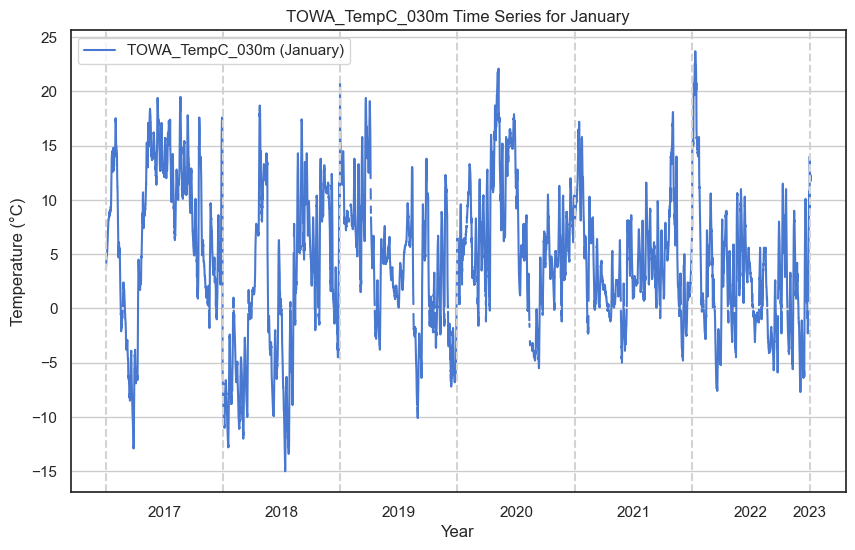

In [32]:
# Group by month
df = combined_df_2
grouped_df = df.groupby(df.index.month)
january_group = grouped_df.get_group(1)  # 1 corresponds to January
series = january_group['TOWA_TempC_030m']

# Generate a continuous range for the x-axis
x = range(len(series.index))

# Extract the years from the index
years = series.index.year

# Create x-ticks for the first occurrence of each year
unique_years = np.unique(years)
year_ticks = [np.where(years == year)[0][0] for year in unique_years]

# Calculate positions for the year labels to be between ticks
year_label_positions = [(year_ticks[i] + year_ticks[i + 1]) / 2 for i in range(len(year_ticks) - 1)]
# Add a label for the last year
year_label_positions.append(year_ticks[-1] + (len(x) - year_ticks[-1]) / 2)

# Plot the series for January
sns.set_palette("muted")
plt.figure(figsize=(10, 6))
plt.plot(x, series, label='TOWA_TempC_030m (January)')
plt.title('TOWA_TempC_030m Time Series for January')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

# Set x-ticks for gridlines at year boundaries
plt.grid(axis='y')
plt.xticks(year_label_positions, unique_years, rotation=0)
plt.tick_params(axis='x', which='both', bottom=False)

# Add vertical gridlines at the year boundaries
for tick in year_ticks:
    plt.axvline(x=tick, color='lightgrey', linestyle='--')

plt.legend()
plt.show()

### 6.b. Group by seasons (i.e., years)
The goal of Mann-Kendall is to see how a timeseries changes over the "seasons." In our case, we want to see how a month changes over the years. So, we have 6 seasons: 2017, 2018, 2019, 2020, 2021, 2022. We will run the Mann-Kendall test on each month to see how the months change over time.

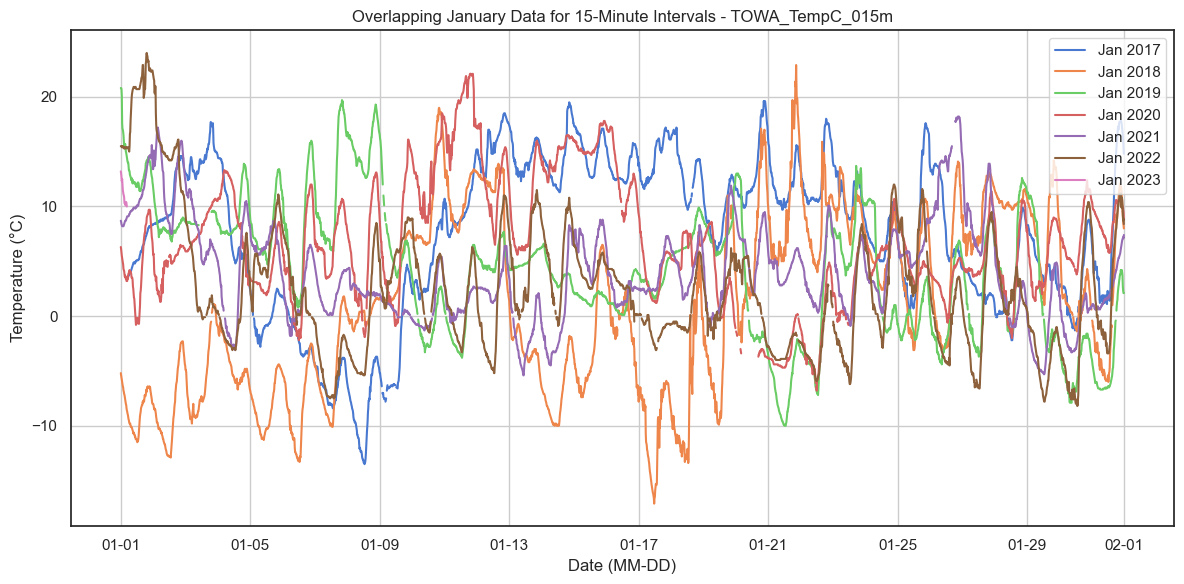

In [33]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Filter the columns for the 'TOWA' tower and the 'TempC' variable
towa_temp_columns = january_df.columns[january_df.columns.str.contains('TOWA') & january_df.columns.str.contains('TempC')]
january_towa_temp_df = january_df[towa_temp_columns]

# Use the muted color palette from Seaborn
palette = sns.color_palette("muted", len(january_towa_temp_df.index.year.unique()))

# Example plotting for one specific tower/height combination
tower_variable_height = towa_temp_columns[0]  # Use the first TOWA TempC column as an example

# Plot the data for each year on the same x-axis without the year information
plt.figure(figsize=(12, 6))

# Loop through each year, align the dates to remove the year for stacking, and plot
for i, year in enumerate(sorted(january_towa_temp_df.index.year.unique())):
    yearly_data = january_towa_temp_df[january_towa_temp_df.index.year == year].copy()
    yearly_data.index = yearly_data.index.map(lambda x: x.replace(year=2000))  # Align years to 2000
    plt.plot(yearly_data.index, yearly_data[tower_variable_height], label=f'Jan {year}', color=palette[i])

# Format the x-axis to show only the month and day
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

# Labels and title
plt.title(f'Overlapping January Data for 15-Minute Intervals - {tower_variable_height}')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.c. Pairwise comparisons
For each month, and every timestamp of that month, do a pairwise comparison across all the seasons (years)

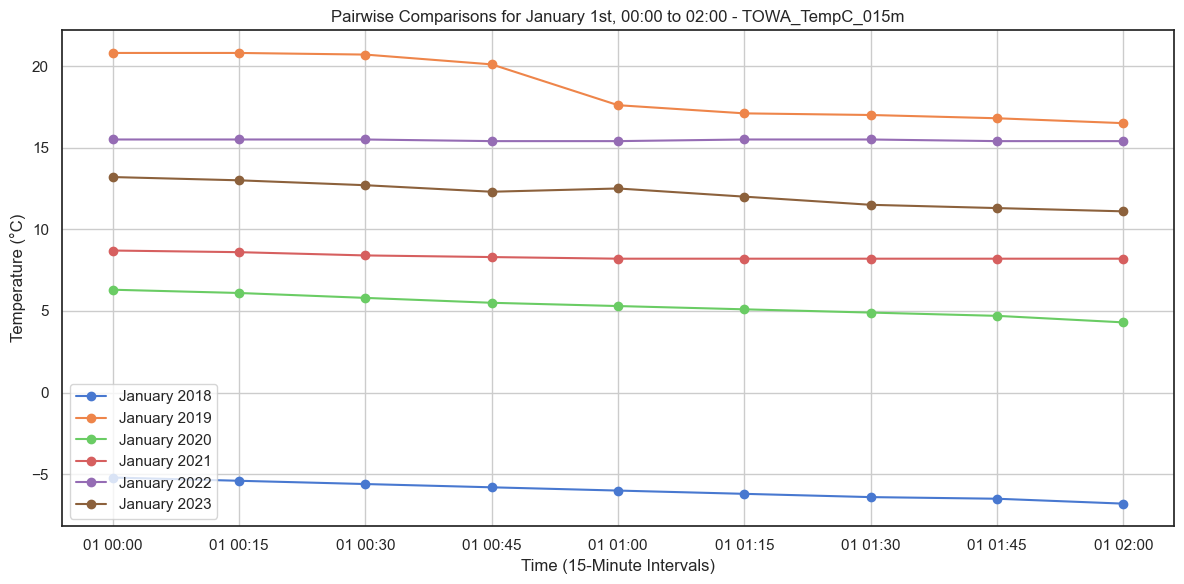

In [34]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Filter the columns for the 'TOWA' tower and the 'TempC' variable
towa_temp_columns = january_df.columns[january_df.columns.str.contains('TOWA') & january_df.columns.str.contains('TempC')]
january_towa_temp_df = january_df[towa_temp_columns]

# Align the dates to remove the year for stacking (this makes the x-axis comparable across years)
stacked_data = []
for year in sorted(january_towa_temp_df.index.year.unique()):
    year_data = january_towa_temp_df[january_towa_temp_df.index.year == year].copy()
    year_data.index = year_data.index.map(lambda x: x.replace(year=2000))
    stacked_data.append(year_data.assign(Year=year))  # Assign year for later use

# Combine the stacked data
stacked_january_df = pd.concat(stacked_data).sort_index()

# Let's zoom in to two hours of data (for example, 1st January from 00:00 to 02:00)
start_time = '2000-01-01 00:00'
end_time = '2000-01-01 02:00'

# Filter the data for this two-hour period
stacked_january_zoom = stacked_january_df.loc[start_time:end_time]

# Example plotting for one specific tower/height combination
tower_variable_height = towa_temp_columns[0]  # Use the first TOWA TempC column as an example

# Plotting
plt.figure(figsize=(12, 6))
palette = sns.color_palette("muted", len(january_towa_temp_df.index.year.unique()))
# Plot the data for each year in this two-hour window in sorted order
for i, year in enumerate(sorted(stacked_january_zoom['Year'].unique())):
    year_data = stacked_january_zoom[stacked_january_zoom['Year'] == year]
    plt.plot(year_data.index, year_data[tower_variable_height], 'o-', label=f'January {year}', color=palette[i])

# Labels and title
plt.title(f'Pairwise Comparisons for January 1st, 00:00 to 02:00 - {tower_variable_height}')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.d. Pairwise differences
Calculate the pairwise differences (a positive difference means upward trend; a negative difference means downward trend)

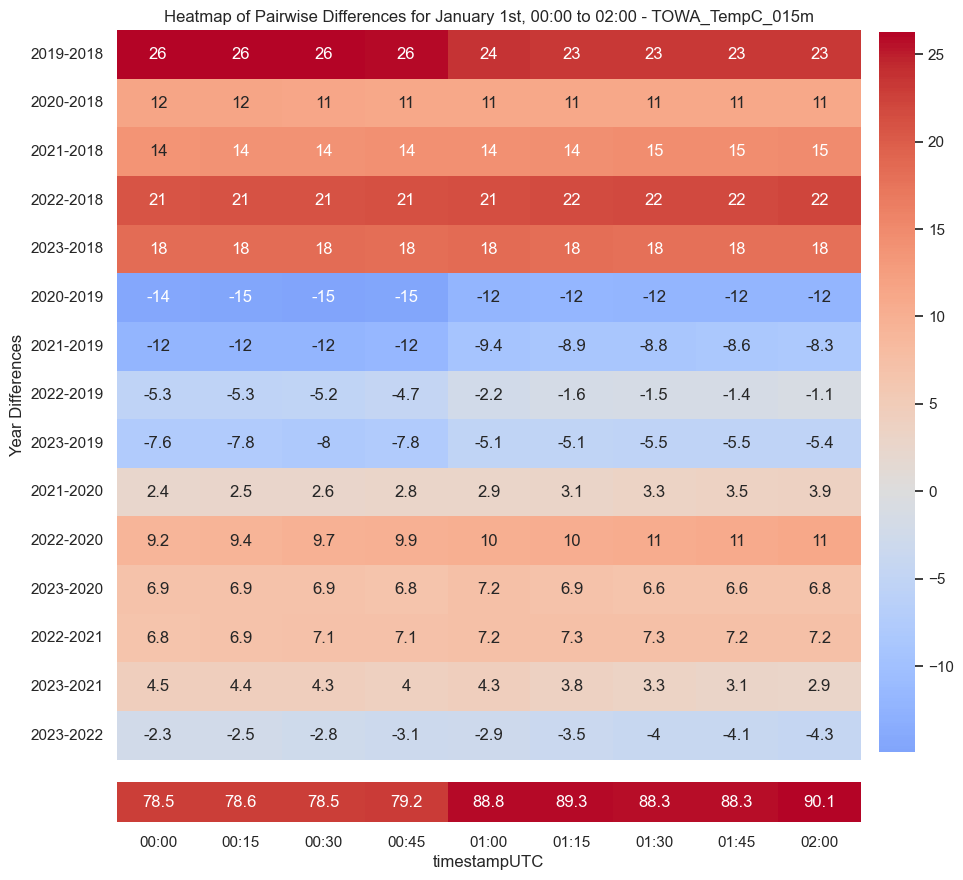

In [35]:
# Initialize a DataFrame to store the pairwise differences
pairwise_diffs = pd.DataFrame(index=stacked_january_zoom.index.unique())

# Calculate pairwise differences and store them in the DataFrame
for year1 in sorted(stacked_january_zoom['Year'].unique()):
    for year2 in sorted(stacked_january_zoom['Year'].unique()):
        if year1 < year2:
            diff_label = f'{year2}-{year1}'
            value1 = stacked_january_zoom[stacked_january_zoom['Year'] == year1][tower_variable_height]
            value2 = stacked_january_zoom[stacked_january_zoom['Year'] == year2][tower_variable_height]
            
            # Calculate the difference and add it to the DataFrame
            pairwise_diffs[diff_label] = value2.values - value1.values

# Format the index to show only the time in HH:MM format
pairwise_diffs.index = pairwise_diffs.index.strftime('%H:%M')
n_rows = len(pairwise_diffs) * 2

# Calculate the sum of pairwise differences for each time point
sum_diffs = pairwise_diffs.sum(axis=1)

# Create a figure with subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, n_rows * 0.5 + 2), gridspec_kw={'height_ratios': [n_rows, 1]}, constrained_layout=False, sharex=True)

# First subplot: Heatmap of pairwise differences
sns.heatmap(pairwise_diffs.T, annot=True, cmap='coolwarm', center=0, ax=ax1, cbar_kws={'shrink': 0.5})
ax1.set_title(f'Heatmap of Pairwise Differences for January 1st, 00:00 to 02:00 - {tower_variable_height}')
ax1.set_xlabel('')  # Remove x-axis label for the top heatmap
ax1.set_ylabel('Year Differences')

# Adjust the position of the colorbar to bring it closer to the plot
cbar = ax1.collections[0].colorbar
cbar.ax.set_position([.76, .223, .03, .657])  # Moving the colorbar closer

# Second subplot: Heatmap of the sum of pairwise differences
sns.heatmap(sum_diffs.to_frame().T, annot=True, fmt='.1f', cmap='coolwarm', center=0, cbar=False, ax=ax2)

# Remove y-axis ticks, tick labels, and the label itself
ax2.set_ylabel('')
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_yticklabels([])  # Remove y-axis tick labels

# Move the bottom heatmap closer to the top heatmap
pos1 = ax1.get_position()
pos2 = ax2.get_position()
ax2.set_position([pos1.x0, pos2.y0 + 0.05, pos1.width, pos2.height])  # Adjust y0 to move it up

plt.show()

### 6.e.1 Sum of S-statistic (zoomed in)
Determine the overall trend direction by summing all of the positive and negative pairwise differences

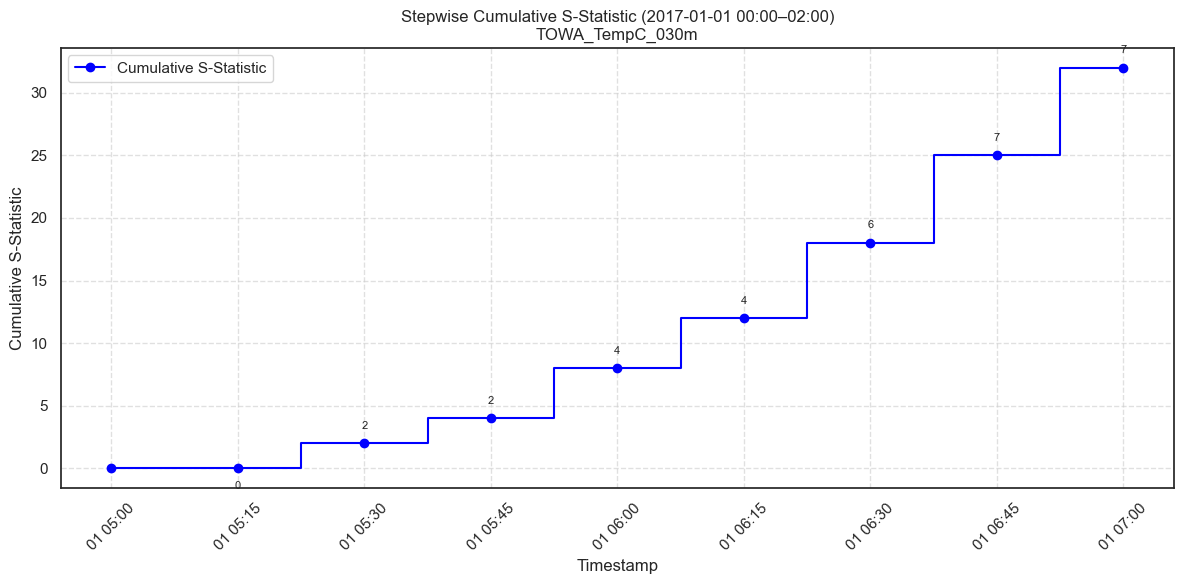

In [36]:
# Use the original DataFrame
df = combined_df_2

# Ensure the index is a datetime index and tz-naive
df.index = pd.to_datetime(df.index).tz_localize(None)

# Step 1: Filter for January
january_df = df[df.index.month == 1]

# Step 2: Select the specific column for 'TOWA_TempC_030m'
series = january_df['TOWA_TempC_030m'].dropna()

# Step 3: Select a two-hour subset (e.g., January 1st from 00:00 to 02:00)
start_time = pd.Timestamp('2017-01-01 05:00:00')
end_time = pd.Timestamp('2017-01-01 07:00:00')
subset_series = series[start_time:end_time]

# Step 4: Compute the S-statistic
s_statistic = np.zeros(len(subset_series))
subset_values = subset_series.values
for i in range(1, len(subset_values)):
    s_statistic[i] = np.sum(np.sign(subset_values[i] - subset_values[:i]))

# Step 5: Cumulative sum of the S-statistic
cumulative_s_stat = np.cumsum(s_statistic)

# Step 6: Plot the cumulative S-statistic
plt.figure(figsize=(12, 6))
plt.step(subset_series.index, cumulative_s_stat, where='mid', label='Cumulative S-Statistic',
         color='blue', marker='o')

# Annotate steps with the S-statistic value
for i in range(1, len(subset_series)):
    y_offset = 1 if s_statistic[i] > 0 else -1
    plt.text(subset_series.index[i], cumulative_s_stat[i] + y_offset,
             f'{int(s_statistic[i])}', ha='center',
             va='bottom' if s_statistic[i] > 0 else 'top', fontsize=8)

# Formatting
plt.title('Stepwise Cumulative S-Statistic (2017-01-01 00:00–02:00)\nTOWA_TempC_030m')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative S-Statistic')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## 6.e.2. Sum of S-Statistic (across all seasons)

/var/folders/3s/1n6wl8w52cb_9hst_c95fb9h0000gp/T/ipykernel_46589/1632112684.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))


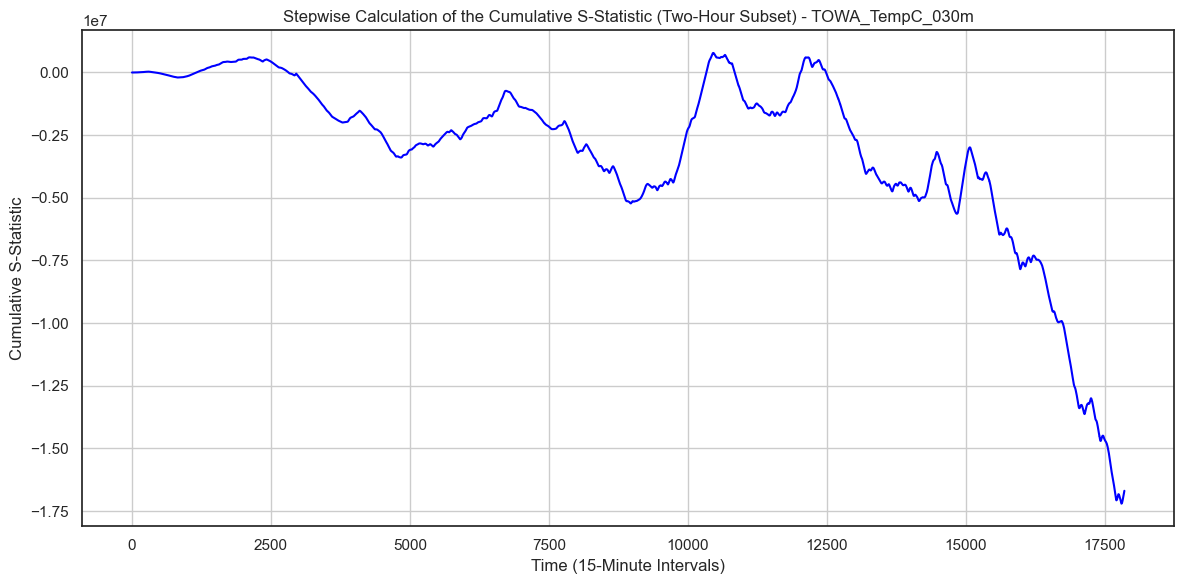

In [37]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Step 1: Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Step 2: Select the specific column for 'TOWA_TempC_030m'
series = january_df['TOWA_TempC_030m']

# Calculate the S-statistic for each time point in the subset
s_statistic = np.zeros(len(series))
for i in range(1, len(series)):
    s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))

# Calculate the cumulative sum of the S-statistic
cumulative_s_stat = np.cumsum(s_statistic)

# Plot the cumulative sum of the S-statistic
plt.figure(figsize=(12, 6))
plt.plot(range(len(series)), cumulative_s_stat, label='Cumulative S-Statistic', color='blue')

# Labels and title
plt.title('Stepwise Calculation of the Cumulative S-Statistic (Two-Hour Subset) - TOWA_TempC_030m')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Cumulative S-Statistic')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.e.3. Compare sum of S-Statistic across all seasons for each tower-variable-height

/var/folders/3s/1n6wl8w52cb_9hst_c95fb9h0000gp/T/ipykernel_46589/460805477.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))


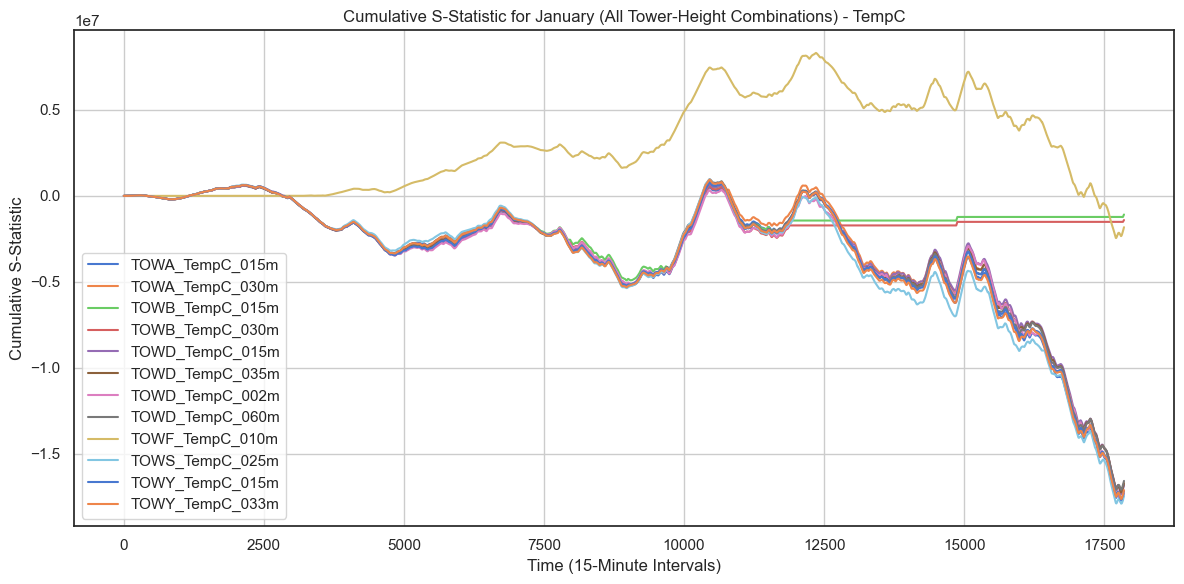

In [38]:
# Assuming `combined_df_2` is your original DataFrame
df = combined_df_2

# Step 1: Filter the DataFrame for January
january_df = df[df.index.month == 1]

# Step 2: Filter columns that contain 'TempC' to get all tower-height combinations
temp_columns = january_df.columns[january_df.columns.str.contains('TempC')]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

# Loop through each 'TempC' tower-height combination
for column in temp_columns:
    series = january_df[column]
    
    # Calculate the S-statistic for each time point in the series
    s_statistic = np.zeros(len(series))
    for i in range(1, len(series)):
        s_statistic[i] = np.sum(np.sign(series[i] - series[:i]))
    
    # Calculate the cumulative sum of the S-statistic
    cumulative_s_stat = np.cumsum(s_statistic)
    
    # Plot the cumulative sum of the S-statistic for the current tower-height combination
    plt.plot(range(len(series)), cumulative_s_stat, label=column)

# Labels and title
plt.title('Cumulative S-Statistic for January (All Tower-Height Combinations) - TempC')
plt.xlabel('Time (15-Minute Intervals)')
plt.ylabel('Cumulative S-Statistic')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

---
---
# 7. Perform the Mann-Kendall Test

In [50]:
# Configure Dask Client
client = Client(
    n_workers=16,  # Number of workers, leaving some cores free
    threads_per_worker=1,  # One thread per worker
    memory_limit='3GB'  # Adjust based on your system's total memory; 4GB is a reasonable start
)

print(client.dashboard_link)

/opt/homebrew/anaconda3/envs/orr_met_env/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64578 instead
  warnings.warn(


http://127.0.0.1:64578/status


## 7.a. Mann-Kendall

In [40]:
# Assuming `combined_df_2` is your original Pandas DataFrame
df = combined_df_2
num_years = len(df.index.year.unique())

# Function to apply seasonal MK test on a Pandas Series
def apply_seasonal_mk(series):
    # Ensure the series has enough data points
    if series.dropna().shape[0] < 12:  # Less than one full year of data
        return pd.Series({'trend': None, 'p': None, 'z': None, 's': None, 'var_s': None})

    try:
        result = seasonal_test(series, period=num_years)  # Assuming monthly seasonality
        return pd.Series({'trend': result.trend, 'p': result.p, 'z': result.z, 's': result.s, 'var_s': result.var_s})
    except ZeroDivisionError:
        return pd.Series({'trend': None, 'p': None, 'z': None, 's': None, 'var_s': None})

# Group by month
grouped_df = df.groupby(df.index.month)

# Initialize a counter to track progress
total_groups = len(grouped_df)
counter = 0

# Define a function that processes each group
def process_group(name, group, counter, total_groups):
    print(f"Processing group {counter + 1} of {total_groups} (Month: {name})")
    result = group.apply(apply_seasonal_mk, axis=0)
    result['month'] = name  # Add the month information as a new column
    return result

# Apply the seasonal MK test in parallel
delayed_tasks = []
for counter, (name, group) in enumerate(grouped_df):
    # Create a delayed object for each group processing
    task = delayed(process_group)(name, group, counter, total_groups)
    delayed_tasks.append(task)

# Compute all tasks in parallel
results = compute(*delayed_tasks)

# Convert results to the desired format (e.g., concatenate into a DataFrame)
final_mk_results = pd.concat(results)

/opt/homebrew/anaconda3/envs/orr_met_env/lib/python3.12/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 92.27 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-04-21 20:00:51,592 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.96 GiB -- Worker memory limit: 2.79 GiB
2025-04-21 20:01:47,741 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/lates

In [41]:
final_mk_results.head(5)

,TOWA_TempC_015m,TOWA_TempC_030m,TOWA_RelHum_015m,TOWA_AbsHum_015m,TOWA_WSpdMph_015m,TOWA_WSpdMph_030m,TOWA_PkWSpdMph_015m,TOWA_PkWSpdMph_030m,TOWA_VSSpdMph_015m,TOWA_VSSpdMph_030m,...,TOWY_Sigma_015m,TOWY_Sigma_033m,TOWY_SigPhi_015m,TOWY_SigPhi_033m,TOWY_WDir_033m,TOWY_WDir_015m,TOWY_PrecipIn_015m,TOWY_year,TOWY_month,month
trend,decreasing,decreasing,decreasing,decreasing,increasing,no trend,increasing,increasing,increasing,increasing,...,decreasing,decreasing,decreasing,decreasing,decreasing,decreasing,no trend,increasing,no trend,1
p,0.0,0.0,0.03541,0.0,0.000061,0.860676,0.00003,0.000004,0.0,0.002918,...,0.0,0.0,0.020781,0.0,0.0,0.0,0.68076,0.0,1.0,1
z,-22.267061,-21.319304,-2.103643,-15.589517,4.007894,0.175514,4.173628,4.599663,6.353107,2.976292,...,-6.891653,-10.127442,-2.311938,-6.353473,-5.09161,-6.856564,-0.411426,169.418771,0,1
s,-2477981.0,-2384836.0,-230325.0,-1686202.0,448166.0,15000.0,463106.0,512606.0,706341.0,333413.0,...,-782002.0,-1149649.0,-259384.0,-707747.0,-578034.0,-779059.0,-19464.0,18984272.0,0.0,1
var_s,12384252147.0,12513265060.666666,11987652740.333332,11699124144.666666,12503840987.333334,7303026291.333333,12312082763.333334,12419772911.333332,12361047875.0,12549067769.666666,...,12875611610.666666,12886359435.000002,12587247770.000002,12408876944.333334,12888283540.666666,12910009640.333334,2237876182.0,12556389957.333332,0.0,1


In [42]:
# Assuming final_results is your DataFrame
sub_tables = []

# Define the significance threshold
significance_threshold = 0.05

# Define the number of decimal places to round to
rounding_decimals = 3

# Extract unique variables by stripping the tower and height parts from the columns
variables = sorted(list(set([col.split('_')[1] for col in final_mk_results.columns if col != 'month'])))

# Iterate over each unique month in the DataFrame
for month in final_mk_results['month'].unique():
    for variable in variables:
        # Extract columns related to the current variable
        related_columns = sorted([col for col in final_mk_results.columns if variable in col.split('_')])
        
        # Filter the DataFrame for the current month
        mask = (final_mk_results['month'] == month)
        filtered_df = final_mk_results.loc[mask]
        
        # Extract the tau and p-value rows
        tau_values = filtered_df.loc['trend', related_columns].values
        p_values = filtered_df.loc['p', related_columns].values
        
        # Round p-values and add an asterisk if below the significance threshold
        p_values_with_significance = [
            f"{round(p, rounding_decimals)}*" if p is not None and not np.isnan(p) and p < significance_threshold 
            else f"{round(p, rounding_decimals)}" if p is not None and not np.isnan(p)
            else "NaN"
            for p in p_values
        ]
        
        # Create a sub-table
        sub_table = pd.DataFrame({
            'tower_variable_height': related_columns,
            'month': [month] * len(related_columns),
            'tau': tau_values,
            'p-value': p_values_with_significance
        })
        
        # Add the sub-table to the list
        sub_tables.append(sub_table)

# sub_tables now contains a list of DataFrames, each representing a variable-month combination

In [43]:
all_subtables = pd.concat(sub_tables, axis=0)
all_subtables

,tower_variable_height,month,tau,p-value
0,TOWA_AbsHum_015m,1,decreasing,0.0*
1,TOWD_AbsHum_002m,1,decreasing,0.0*
2,TOWD_AbsHum_015m,1,decreasing,0.0*
3,TOWF_AbsHum_010m,1,increasing,0.0*
0,TOWA_BarPresMb_015m,1,decreasing,0.0*
...,...,...,...,...
1,TOWB_year,12,increasing,0.0*
2,TOWD_year,12,increasing,0.0*
3,TOWF_year,12,increasing,0.0*
4,TOWS_year,12,increasing,0.0*


## 7.b. Sen's slope

In [51]:
# Your input DataFrame with datetime index
df = combined_df_2
num_years = len(df.index.year.unique())

# Function to apply seasonal Sen's slope
def apply_seasonal_sens_slope(series):
    if series.dropna().shape[0] < 12:
        return pd.Series({'slope': None, 'intercept': None})
    try:
        result = seasonal_sens_slope(series.to_numpy(), period=num_years)
        return pd.Series({'slope': result.slope, 'intercept': result.intercept})
    except ZeroDivisionError:
        return pd.Series({'slope': None, 'intercept': None})

# Process a single month's group
def process_month(month, group, idx, total):
    print(f"Processing month {month} ({idx + 1} of {total})")
    result = group.apply(apply_seasonal_sens_slope, axis=0)
    result['month'] = month
    return result

# Group by month and prepare delayed tasks
monthly_groups = [(month, group.copy()) for month, group in df.groupby(df.index.month)]
total_groups = len(monthly_groups)

delayed_tasks = [
    delayed(process_month)(month, group, idx, total_groups)
    for idx, (month, group) in enumerate(monthly_groups)
]

# Compute in parallel
results = compute(*delayed_tasks)

# Combine results
final_sens_slope_results = pd.concat(results)

# Clean up memory
del df, monthly_groups, delayed_tasks, results
gc.collect()

/opt/homebrew/anaconda3/envs/orr_met_env/lib/python3.12/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 92.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-04-21 20:15:47,798 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.97 GiB -- Worker memory limit: 2.79 GiB
2025-04-21 20:15:50,797 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/lates

3359

In [52]:
final_sens_slope_results.head(2)

,TOWA_TempC_015m,TOWA_TempC_030m,TOWA_RelHum_015m,TOWA_AbsHum_015m,TOWA_WSpdMph_015m,TOWA_WSpdMph_030m,TOWA_PkWSpdMph_015m,TOWA_PkWSpdMph_030m,TOWA_VSSpdMph_015m,TOWA_VSSpdMph_030m,...,TOWY_Sigma_015m,TOWY_Sigma_033m,TOWY_SigPhi_015m,TOWY_SigPhi_033m,TOWY_WDir_033m,TOWY_WDir_015m,TOWY_PrecipIn_015m,TOWY_year,TOWY_month,month
slope,-0.001664,-0.001583,-0.000331,-0.000477,0.000071,0.0,0.000192,0.000248,0.000007,0.0,...,-0.000476,-0.000631,-0.000095,-0.000281,-0.002417,-0.003362,0.0,0.002252,0.0,1
intercept,6.411702,6.512433,76.214970,5.098433,2.911022,4.3,6.458626,7.687925,-0.069177,0.0,...,17.006457,14.704191,8.120236,10.754532,217.081501,209.288184,0.0,2017.127735,1.0,1


In [53]:
# Assuming final_results is your DataFrame
sub_tables_2 = []

# Define the number of decimal places to round to
rounding_decimals = 3

# Extract unique variables by stripping the tower and height parts from the columns
variables = sorted(list(set([col.split('_')[1] for col in final_sens_slope_results.columns if col != 'month'])))

# Iterate over each unique month in the DataFrame
for month in final_sens_slope_results['month'].unique():
    for variable in variables:
        # Extract columns related to the current variable
        related_columns = sorted([col for col in final_sens_slope_results.columns if variable in col.split('_')])
        
        # Filter the DataFrame for the current month
        mask = (final_sens_slope_results['month'] == month)
        filtered_df = final_sens_slope_results.loc[mask]
        
        # Extract the tau and p-value rows
        slope_values = filtered_df.loc['slope', related_columns].values
        int_values = filtered_df.loc['intercept', related_columns].values
        
        # Create a sub-table
        sub_table = pd.DataFrame({
            'tower_variable_height': related_columns,
            'month': [month] * len(related_columns),
            'sens_slope': slope_values,
            'sens_slope_intercept': int_values
        })
        
        # Add the sub-table to the list
        sub_tables_2.append(sub_table)

# sub_tables now contains a list of DataFrames, each representing a variable-month combination

In [54]:
all_subtables_wsens = pd.concat(sub_tables_2)

In [55]:
all_subtables_wsens

,tower_variable_height,month,sens_slope,sens_slope_intercept
0,TOWA_AbsHum_015m,1,-0.000477,5.098433
1,TOWD_AbsHum_002m,1,-0.000435,4.954889
2,TOWD_AbsHum_015m,1,-0.000456,4.877384
3,TOWF_AbsHum_010m,1,0.000405,3.901851
0,TOWA_BarPresMb_015m,1,-0.001071,990.270398
...,...,...,...,...
1,TOWB_year,12,0.002249,2016.63188
2,TOWD_year,12,0.002249,2016.63188
3,TOWF_year,12,0.002249,2016.63188
4,TOWS_year,12,0.002249,2016.63188


In [56]:
complete_results = pd.merge(left=all_subtables, right=all_subtables_wsens, on=['tower_variable_height', 'month'])
complete_results['sens_slope'] = round(complete_results['sens_slope'], 3)
complete_results['sens_slope_intercept'] = round(complete_results['sens_slope_intercept'], 3)
complete_results

,tower_variable_height,month,tau,p-value,sens_slope,sens_slope_intercept
0,TOWA_AbsHum_015m,1,decreasing,0.0*,-0.000477,5.098433
1,TOWD_AbsHum_002m,1,decreasing,0.0*,-0.000435,4.954889
2,TOWD_AbsHum_015m,1,decreasing,0.0*,-0.000456,4.877384
3,TOWF_AbsHum_010m,1,increasing,0.0*,0.000405,3.901851
4,TOWA_BarPresMb_015m,1,decreasing,0.0*,-0.001071,990.270398
...,...,...,...,...,...,...
1363,TOWB_year,12,increasing,0.0*,0.002249,2016.63188
1364,TOWD_year,12,increasing,0.0*,0.002249,2016.63188
1365,TOWF_year,12,increasing,0.0*,0.002249,2016.63188
1366,TOWS_year,12,increasing,0.0*,0.002249,2016.63188


In [57]:
complete_results.to_csv('../data/mk_theilsen_results.csv', index=False)

## Monthly sen's slope distributions (example; not working code)

In [58]:
# dfs = []
# for df, tower_name in zip(tower_dfs_15m_clean, towers_of_interest):
#     df = df.rename(columns=lambda x: f"{tower_name}_{x}")
#     dfs.append(df)
# combined_df_2 = pd.concat(dfs, axis=1)
# combined_df_2 = combined_df_2.astype(np.float32)

# # Add month and year columns
# combined_df_2['Year'] = combined_df_2.index.year
# combined_df_2['Month'] = combined_df_2.index.month

# # Group by Year and Month and calculate statistics
# monthly_stats = combined_df_2.groupby(['Year', 'Month']).agg(['max', 'min', 'mean', 'median'])

# # Function to apply Theil-Sen regression for each group
# def apply_theilslopes_group(df):
#     results = {}
#     for name, group in df.groupby('Month'):  # Group by Month
#         ordinal_index = pd.to_datetime(group.index.get_level_values('Year'), format='%Y').map(pd.Timestamp.toordinal)
#         for col in df.columns.levels[0]:  # Iterate over tower_variable_height columns
#             for stat in ['max', 'min', 'mean', 'median']:  # Iterate over each statistic
#                 data = group[(col, stat)]
#                 slope, intercept, _, _ = theilslopes(data, ordinal_index)
#                 results[(col, stat, name)] = (slope, intercept)
#     return pd.DataFrame(results)

# # Apply the function to the DataFrame
# theilslopes_results = apply_theilslopes_group(monthly_stats)

# # Transpose the DataFrame for easier manipulation
# theilslopes_results = theilslopes_results.T
# theilslopes_results.columns = ['Slope', 'Intercept']
# theilslopes_results.index.names = ['tower_variable_height', 'Statistic', 'Month']

# # Extract the variable names (e.g., TempC, BarPresMb) from the tower_variable_height column
# theilslopes_results['Variable'] = theilslopes_results.index.get_level_values('tower_variable_height').str.split('_').str[1]

# # Reset index to have a flat DataFrame
# theilslopes_results = theilslopes_results.reset_index()

# # Group by Variable, Statistic, and Month for plotting
# grouped_results = theilslopes_results.groupby(['Variable', 'Statistic', 'Month', 'tower_variable_height'])['Slope'].mean().reset_index()

# # Set the Seaborn color palette
# sns.set_palette('pastel')

# # Get the unique variables to create one plot for each
# variables = grouped_results['Variable'].unique()

# # Mapping month numbers to three-letter month abbreviations
# month_abbr = [calendar.month_abbr[i] for i in range(1, 13)]

# for variable in variables:
#     # Filter the data for the current variable
#     variable_data = grouped_results[grouped_results['Variable'] == variable]
    
#     # Set up the subplots
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#     fig.suptitle(f'Sen\'s Slope for {variable} by Month', fontsize=16, y=0.91)  # Adjusted suptitle position
    
#     # Define the statistics and corresponding axes
#     stats = ['min', 'max', 'mean', 'median']
#     ax_dict = {'min': axes[0, 0], 'max': axes[0, 1], 'mean': axes[1, 0], 'median': axes[1, 1]}
    
#     for stat in stats:
#         ax = ax_dict[stat]
#         # Filter data for the current statistic
#         stat_data = variable_data[variable_data['Statistic'] == stat]
        
#         # Create a boxplot with a red median line
#         sns.boxplot(x='Month', y='Slope', data=stat_data, ax=ax,
#                     medianprops={'color': 'red', 'linewidth': 1})
#         ax.set_title(f'{stat.capitalize()} {variable}')
        
#         # Align the x-axis labels with the actual boxplot positions
#         ax.set_xticks(ax.get_xticks())  # Ensure ticks match the boxplot positions
#         ax.set_xticklabels(month_abbr, ha='center')
        
#         # Calculate the positions for the dashed lines between the boxplots
#         ticks = ax.get_xticks()
#         midpoints = [(ticks[i] + ticks[i+1]) / 2 for i in range(len(ticks)-1)]
        
#         # Add light grey dashed lines at the midpoints
#         for midpoint in midpoints:
#             ax.axvline(x=midpoint, color='lightgrey', linestyle='--', linewidth=1)
        
#         # Only set y-axis labels on the left subplots
#         if stat in ['min', 'mean']:
#             ax.set_ylabel('Sen\'s Slope')
#         else:
#             ax.set_ylabel('')  # Remove y-axis label
        
#         # Remove the "Month" label from the x-axis
#         ax.set_xlabel('')
#         ax.tick_params(axis='x', bottom=False)  # Remove x-axis ticks
    
#     # Adjust layout
#     plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust rect to fit the title better
#     plt.show()